<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw13/Homework13_realnvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 414 (delta 104), reused 79 (delta 79), pack-reused 250
Receiving objects: 100% (414/414), 70.33 MiB | 17.08 MiB/s, done.
Resolving deltas: 100% (198/198), done.
Checking out files: 100% (56/56), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=28255 sha256=4bd1a0aaddb5d31f0ecb183741a1bbe687092e08ae13062618aff2fb3599dbb8
  Stored in directory: /tmp/pip-ephem-wheel-cache

In [2]:
from dul_2021.utils.hw13_utils import *

In [3]:
from tqdm.notebook import tqdm

In [4]:
!pip install einops

In [5]:
import os
import numpy as np
import copy
from itertools import chain
import einops

import torch
import torch.nn as nn
import torch.optim as opt
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Question 1: RealNVP on Higher Dimensions


In this problem, you will train a flow model to invertibly map a high dimensional dataset of celebrity
faces to gaussian noise. The dataset is a low-resolution (32 × 32) version of the CelebA-HQ dataset that has been quantized to 2 bits per color channel.



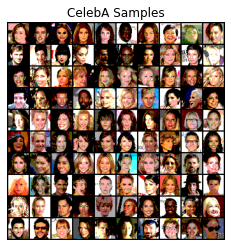

In [ ]:
visualize_q1_data()

## Part (a): RealNVP


Use the affine coupling flow from RealNVP and a form of [data-dependent initialization](https://arxiv.org/abs/1602.07868) that normalizes activations from an initial forward pass with a minibatch.
We describe a reference architecture below that can achieve good performance, but you are free
and encouraged to use different architectures and/or structure your code differently.



```
Preprocess() # dequantization, logit trick from RealNVP (Dinh et al) Section 4.1

for _ in range(4):
  AffineCouplingWithCheckerboard() # Figure 3 in Dinh et al - (left)
  ActNorm() # described in Glow (Kingma & Dhariwal) Section 3.1
Squeeze(), # [b, c, h, w] --> [b, c*4, h//2, w//2]

for _ in range(3):
  AffineCouplingWithChannel()
  ActNorm()
Unsqueeze(), # [b, c*4, h//2, w//2] --> [b, c, h, w]

for _ in range(3):
  AffineCouplingWithCheckerboard()
  ActNorm()
```



Here, we provide pseudocode for the basic structure of each coupling layer. 



```
# pseudocode
ResnetBlock: n_filters
  h = x
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (3,3), stride=1, padding=1)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  return h + x

SimpleResnet: n_filters = 256, n_blocks = 8, n_out
  conv2d(in_channels, n_filters=128, (3,3), stride=1, padding=1)
  apply 8 ResnetBlocks with n_filters=128
  relu()
  conv2d(n_filters, n_filters=n_out, (3,3), stride=1, padding=1)
  
AffineCoupling(x, mask):
  x_ = x * mask
  log_s, t = torch.chunk(SimpleResnet(x_), 2, dim=1)
  # todo: calculate log_scale, as done in Q1(b)
  t = t * (1.0 - mask)
  log_scale = log_scale * (1.0 - mask)
  z = x * torch.exp(log_scale) + t
  log_det_jacobian = log_scale
  return z, log_det_jacobian
```



We use an Adam Optimizer with a warmup over 200 steps till a learning rate of 5e-4. We didn’t decay the learning rate but it is a generally recommended practice while training generative models. We show samples from our model at the end of training, as well as interpolations between several images in our dataset.  Our reference solution achieves a test loss of about 0.40 bits/dim after 100 epochs. 



**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model
4. 5 rows of interpolations between images in the test set; each row consists of the start and end images, and 4 intermediate ones. You should return 30 total images. 



### Main classes

In [8]:
class ResBlock(nn.Module):
  def __init__(self, n_filters):
    super().__init__()
    self.block = nn.Sequential(nn.Conv2d(n_filters, n_filters, 1),
                               nn.ReLU(),
                               nn.Conv2d(n_filters, n_filters, 3, 1, 1),
                               nn.ReLU(),
                               nn.Conv2d(n_filters, n_filters, 1))
    
  def forward(self, x):
    return x + self.block(x)

In [9]:
class Resnet(nn.Module):
  def __init__(self, n_filters, in_filters=3, out_filters=6, n_block=6):
    super().__init__()
    res_blocks = nn.Sequential(*[ResBlock(n_filters) for _ in range(n_block)])
    self.convs = nn.Sequential(nn.Conv2d(in_filters, n_filters, 3, 1, 1),
                               res_blocks,
                               nn.ReLU(),
                               nn.Conv2d(n_filters, out_filters, 3, 1, 1))
    
  def forward(self, x):
    return self.convs(x)

In [10]:
class AffineCoupling(nn.Module):
  def __init__(self, mask, n_filters=128, in_filters=3, out_filters=6):
    super().__init__()
    self.affine = Resnet(n_filters, in_filters, out_filters)
    
    self.mask = mask
    self.mask_idx = mask.bool()
    
    self.c_mask = 1 - mask
    self.cmask_idx = self.c_mask.bool()

  def forward(self, x):
    x, acc = x
    x_masked = x * self.mask

    t, log_s = torch.chunk(self.affine(x_masked), 2, 1)
    log_s = 0.6 * F.tanh(log_s)
    log_det = (log_s * self.c_mask).sum(dim=(1, 2, 3))

    y = log_s.exp() * (x + t)
    y = x_masked + y * self.c_mask

    return y, acc + log_det

  def inverse(self, z):
    z_masked = z * self.mask

    t, log_s = torch.chunk(self.affine(z_masked), 2, 1)
    log_s = 0.6 * F.tanh(log_s)

    x = (- log_s).exp() * z - t
    x = z_masked + x * self.c_mask

    return x

In [11]:
class ActNorm(nn.Module):
  def __init__(self, num_of_channels):
    super().__init__()
    self.log_Ɣ = nn.Parameter(torch.zeros((num_of_channels, 1, 1), device=device))
    self.β = nn.Parameter(torch.zeros((num_of_channels, 1, 1), device=device))
  
  def forward(self, x):
    x, acc = x
    log_det = self.log_Ɣ.sum() * x.shape[-1] * x.shape[-2]
    return x * self.log_Ɣ.exp() + self.β, acc + log_det

  def inverse(self, z):
    return (- self.log_Ɣ).exp() * (z - self.β)

  def reinit(self, mean, std):
    self.β.data = mean.reshape(-1, 1, 1)
    self.log_Ɣ.data = - std.log().reshape(-1, 1, 1)

In [12]:
class TransformLayer(nn.Module):
  def __init__(self, squeeze=True):
    super().__init__()
    self.expression = 'b (u v c) h w -> b c (h u) (w v)'
    if squeeze:
      self.expression = 'b c (h u) (w v) -> b (u v c) h w'

  def forward(self, x):
    y = einops.rearrange(x[0], self.expression, u=2, v=2)
    return y, x[1]

In [13]:
class RealNVP(nn.Module):
  def __init__(self, sample_size, n_filters=128):
    super().__init__()

    h, w = sample_size
    checker = torch.zeros((3, h, w), device=device)
    for i in range(h):
      for j in range(w):
        checker[:, i, j] = (i + j) % 2
    checker_mask = [checker, 1 - checker, checker]

    chan = torch.zeros((3 * 4, h // 2, w // 2), device=device)
    chan[:6] = 1.
    channel_mask = [chan, 1 - chan, chan, 1 - chan]

    self.tuples4c1 = [(AffineCoupling(mask, n_filters), ActNorm(3)) for mask in checker_mask]
    self.coupling_1 = nn.Sequential(*chain(*self.tuples4c1))

    self.tuples4c2 = [(AffineCoupling(mask, n_filters * 4, 3 * 4, 3 * 4 * 2), ActNorm(3 * 4)) for mask in channel_mask]
    self.coupling_2 = nn.Sequential(*chain(*self.tuples4c2))

    self.tuples4c3 = [(AffineCoupling(mask, n_filters), ActNorm(3)) for mask in checker_mask]
    self.coupling_3 = nn.Sequential(*chain(*self.tuples4c3))

    self.squeeze = TransformLayer()
    self.unsqueeze = TransformLayer(False)

    self.flow = nn.Sequential(self.coupling_1, self.squeeze,
                              self.coupling_2, self.unsqueeze,
                              self.coupling_3)
      
  def forward(self, x):
    return self.flow((x, 0))

  def inverse(self, z):
    final_blocks = list(chain(*self.tuples4c3))
    for layer in reversed(final_blocks):
      z = layer.inverse(z)

    z = einops.rearrange(z, 'b c (h u) (w v) -> b (u v c) h w', u=2, v=2)

    medium_blocks = list(chain(*self.tuples4c2))
    for layer in reversed(medium_blocks):
      z = layer.inverse(z)

    z = einops.rearrange(z, 'b (u v c) h w -> b c (h u) (w v)', u=2, v=2)

    first_blocks = list(chain(*self.tuples4c1))
    for layer in reversed(first_blocks):
      z = layer.inverse(z)

    return z

  def init_actnorm(self, x: "first minibatch"):
    x = self.normalize_over_tuples(self.tuples4c1, x)

    x, _ = self.squeeze((x, 0))
    x = self.normalize_over_tuples(self.tuples4c2, x)

    x, _ = self.unsqueeze((x, 0))
    x = self.normalize_over_tuples(self.tuples4c3, x)

  def normalize_over_tuples(self, tuples, x):
    for coupling, actnorm in tuples:
      x, _ = coupling((x, 0))
      y, _ = actnorm((x, 0))

      mean = y.mean(dim=(0, 2, 3))
      std = y.std(dim=(0, 2, 3))
      actnorm.reinit(mean, std)

      x, _ = actnorm((x, 0))
    
    return x

### Model, optimizer, hyperparameters

In [14]:
from torch.optim import Adam

size = (32, 32)
model = RealNVP(size).to(device)
saved_epoch = -1
#saved_parameters = deepcopy(torch.load(f'/content/drive/MyDrive/RealNVP/real_nvp_{saved_epoch}.pt'))
#model.load_state_dict(saved_parameters)

opt = Adam(model.parameters(), 1e-4)

batch_size = 64
n_epochs = 10
target = Normal(torch.zeros((3, *size), device=device), torch.ones((3, *size), device=device))

### Load data

In [15]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

data_dir = get_data_dir(13)
train_data_np, test_data_np = load_pickled_data(join(data_dir, 'celeb.pkl'))


class MyDataset(Dataset):
  def __init__(self, data):
    self.data = torch.tensor(train_data_np).permute(0, 3, 1, 2).float()

  def __getitem__(self, idx):
    return self.data[idx]
  
  def __len__(self):
    return self.data.shape[0]

train_dataset = MyDataset(train_data_np)
train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [16]:
!nvidia-smi

Tue Mar  8 15:10:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    76W / 149W |    833MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Scaling factor `0.6`

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


	log_pz = -6.1715
	log_d = -44.3909
	log_pz = -1.7527
	log_d = -1601.9458
	log_pz = -1.4008
	log_d = -2217.2109
	log_pz = -1.2850
	log_d = -2615.4951
	log_pz = -1.1940
	log_d = -2777.4082
	log_pz = -1.1494
	log_d = -2981.2817
	log_pz = -1.1158
	log_d = -3064.0481
	log_pz = -1.0948
	log_d = -3116.5930
	log_pz = -1.0818
	log_d = -3130.9644
	log_pz = -1.0855
	log_d = -3171.1628
	log_pz = -1.0710
	log_d = -3085.4316
	log_pz = -1.0692
	log_d = -3078.5959
	log_pz = -1.0675
	log_d = -3000.5625
	log_pz = -1.0667
	log_d = -2973.1282
	log_pz = -1.0797
	log_d = -2967.8784
	log_pz = -1.0828
	log_d = -2910.7153
	log_pz = -1.0821
	log_d = -2750.8877
	log_pz = -1.0886
	log_d = -2654.7952
	log_pz = -1.0915
	log_d = -2590.1396
	log_pz = -1.0961
	log_d = -2451.1987
	log_pz = -1.1044
	log_d = -2422.1858
	log_pz = -1.1174
	log_d = -2305.8843
	log_pz = -1.1166
	log_d = -2195.8706
	log_pz = -1.1267
	log_d = -2059.2375
	log_pz = -1.1303
	log_d = -1991.0586
	log_pz = -1.1416
	log_d = -1897.7523
	log_pz = -1.1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


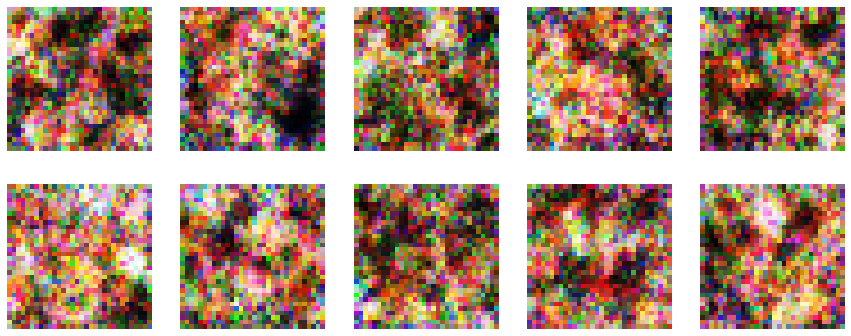

	log_pz = -1.3929
	log_d = -36.0809
	log_pz = -1.3789
	log_d = 101.0825
	log_pz = -1.3975
	log_d = -117.0669
	log_pz = -1.3919
	log_d = -90.4372
	log_pz = -1.3647
	log_d = 14.2509
	log_pz = -1.3929
	log_d = -13.0720
	log_pz = -1.3950
	log_d = -42.6711
	log_pz = -1.3816
	log_d = -22.9068
	log_pz = -1.3817
	log_d = 34.6409
	log_pz = -1.3669
	log_d = 10.9056
	log_pz = -1.3887
	log_d = 76.9624
	log_pz = -1.3721
	log_d = -1.2253
	log_pz = -1.4026
	log_d = 55.4749
	log_pz = -1.3975
	log_d = 62.1836
	log_pz = -1.3894
	log_d = 7.4455
	log_pz = -1.3922
	log_d = 143.6640
	log_pz = -1.3888
	log_d = 178.7328
	log_pz = -1.3936
	log_d = 155.4861
	log_pz = -1.3781
	log_d = 159.2405
	log_pz = -1.3783
	log_d = 132.7236
	log_pz = -1.3815
	log_d = 320.3829
	log_pz = -1.3874
	log_d = 214.1962
	log_pz = -1.3804
	log_d = 223.1531
	log_pz = -1.4006
	log_d = 348.1256
	log_pz = -1.4167
	log_d = 320.8792
	log_pz = -1.4013
	log_d = 290.1298
	log_pz = -1.4069
	log_d = 289.2815
	log_pz = -1.4054
	log_d = 250.3862


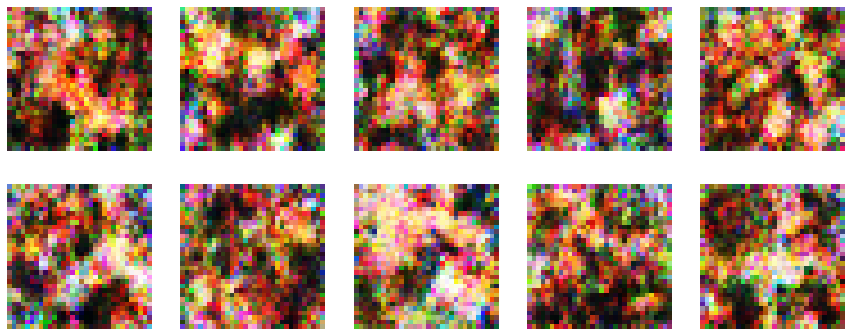

	log_pz = -1.3953
	log_d = 660.5705
	log_pz = -1.3736
	log_d = 696.4196
	log_pz = -1.3780
	log_d = 593.7656
	log_pz = -1.3958
	log_d = 731.9893
	log_pz = -1.3895
	log_d = 584.6310
	log_pz = -1.4075
	log_d = 901.5628
	log_pz = -1.4010
	log_d = 728.7884
	log_pz = -1.4029
	log_d = 678.9589
	log_pz = -1.4113
	log_d = 803.8813
	log_pz = -1.4044
	log_d = 717.3860
	log_pz = -1.3874
	log_d = 884.5763
	log_pz = -1.3783
	log_d = 779.9156
	log_pz = -1.3935
	log_d = 904.7131
	log_pz = -1.4315
	log_d = 1064.2898
	log_pz = -1.4308
	log_d = 898.4762
	log_pz = -1.3922
	log_d = 803.1327
	log_pz = -1.4309
	log_d = 713.1578
	log_pz = -1.4126
	log_d = 782.0752
	log_pz = -1.3813
	log_d = 792.0800
	log_pz = -1.3834
	log_d = 819.9903
	log_pz = -1.3827
	log_d = 936.5396
	log_pz = -1.4092
	log_d = 606.7042
	log_pz = -1.4081
	log_d = 787.5146
	log_pz = -1.4043
	log_d = 823.6530
	log_pz = -1.3880
	log_d = 847.5856
	log_pz = -1.3977
	log_d = 891.9156
	log_pz = -1.3835
	log_d = 1014.6910
	log_pz = -1.3982
	log_d =

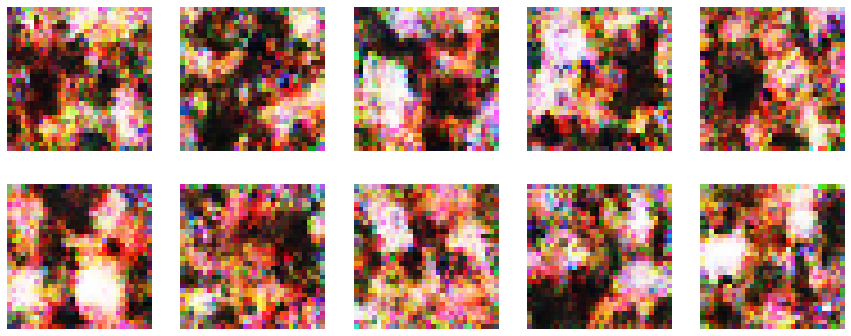

	log_pz = -1.4067
	log_d = 1180.0156
	log_pz = -1.4155
	log_d = 1099.6293
	log_pz = -1.4003
	log_d = 1139.2098
	log_pz = -1.4062
	log_d = 1156.5938
	log_pz = -1.3928
	log_d = 1416.1824
	log_pz = -1.4290
	log_d = 1108.5812
	log_pz = -1.4055
	log_d = 1196.4779
	log_pz = -1.4070
	log_d = 1042.9131
	log_pz = -1.3820
	log_d = 1136.9905
	log_pz = -1.4075
	log_d = 1227.9163
	log_pz = -1.3926
	log_d = 1198.4275
	log_pz = -1.4161
	log_d = 1274.5250
	log_pz = -1.4464
	log_d = 1098.0083
	log_pz = -1.3879
	log_d = 1225.2946
	log_pz = -1.4781
	log_d = 1277.3655
	log_pz = -1.4467
	log_d = 880.0618
	log_pz = -1.4061
	log_d = 684.7473
	log_pz = -1.3522
	log_d = 869.3500
	log_pz = -1.3727
	log_d = 945.5522
	log_pz = -1.3837
	log_d = 819.4179
	log_pz = -1.3813
	log_d = 882.8783
	log_pz = -1.3630
	log_d = 1101.6421
	log_pz = -1.3524
	log_d = 885.9722
	log_pz = -1.3697
	log_d = 904.6071
	log_pz = -1.3963
	log_d = 942.7526
	log_pz = -1.3912
	log_d = 1279.4395
	log_pz = -1.4244
	log_d = 1077.0989
	log_pz = 

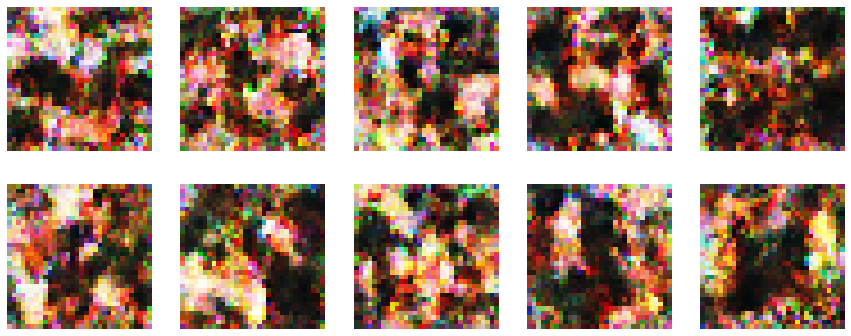

	log_pz = -1.3938
	log_d = 1377.5403
	log_pz = -1.4163
	log_d = 1400.6682
	log_pz = -1.4059
	log_d = 1557.1891
	log_pz = -1.3928
	log_d = 1375.0229
	log_pz = -1.3859
	log_d = 1242.6519
	log_pz = -1.4024
	log_d = 1549.1562
	log_pz = -1.4146
	log_d = 1366.8748
	log_pz = -1.4049
	log_d = 1357.9923
	log_pz = -1.4053
	log_d = 1355.8068
	log_pz = -1.3957
	log_d = 1535.5155
	log_pz = -1.4080
	log_d = 1246.2966
	log_pz = -1.4011
	log_d = 1576.5295
	log_pz = -1.4068
	log_d = 1442.7371
	log_pz = -1.4214
	log_d = 1459.3513
	log_pz = -1.4265
	log_d = 1391.2761
	log_pz = -1.4039
	log_d = 1238.3823
	log_pz = -1.3919
	log_d = 1529.8601
	log_pz = -1.4147
	log_d = 1353.1876
	log_pz = -1.3830
	log_d = 1332.1294
	log_pz = -1.3809
	log_d = 1467.0635
	log_pz = -1.4168
	log_d = 1456.9125
	log_pz = -1.4125
	log_d = 1698.3833
	log_pz = -1.4196
	log_d = 1584.1187
	log_pz = -1.3973
	log_d = 1533.3623
	log_pz = -1.4703
	log_d = 1366.1489
	log_pz = -1.4165
	log_d = 1563.0945
	log_pz = -1.3901
	log_d = 1553.0291
	

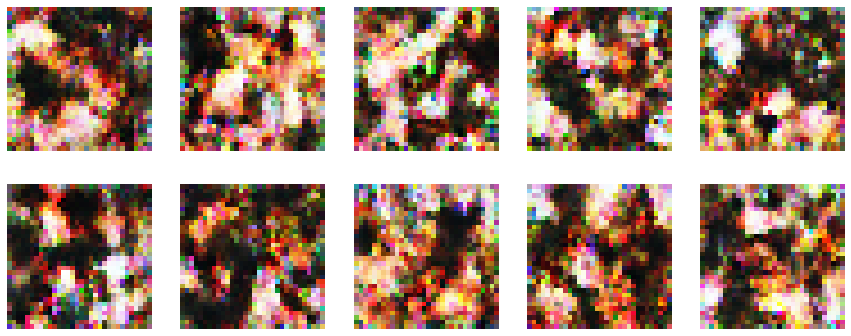

	log_pz = -1.4020
	log_d = 1479.4072
	log_pz = -1.3874
	log_d = 1632.2026
	log_pz = -1.3994
	log_d = 1554.8337
	log_pz = -1.4122
	log_d = 1487.2113
	log_pz = -1.4094
	log_d = 1520.6948
	log_pz = -1.4204
	log_d = 1483.9865
	log_pz = -1.4004
	log_d = 1698.3433
	log_pz = -1.4048
	log_d = 1640.8931
	log_pz = -1.4102
	log_d = 1407.9158
	log_pz = -1.4016
	log_d = 1606.6045
	log_pz = -1.4104
	log_d = 1540.6798
	log_pz = -1.4131
	log_d = 1683.0741
	log_pz = -1.4102
	log_d = 1506.6733
	log_pz = -1.3952
	log_d = 1614.9628
	log_pz = -1.3941
	log_d = 1641.8546
	log_pz = -1.4234
	log_d = 1486.1809
	log_pz = -1.3965
	log_d = 1859.2578
	log_pz = -1.4237
	log_d = 1519.2557
	log_pz = -1.3891
	log_d = 1680.7183
	log_pz = -1.4306
	log_d = 1661.5012
	log_pz = -1.4039
	log_d = 1902.5781
	log_pz = -1.4174
	log_d = 1450.9320
	log_pz = -1.4117
	log_d = 1477.3677
	log_pz = -1.4082
	log_d = 1624.9797
	log_pz = -1.4046
	log_d = 1530.4397
	log_pz = -1.3999
	log_d = 1657.8370
	log_pz = -1.3966
	log_d = 1689.6509
	

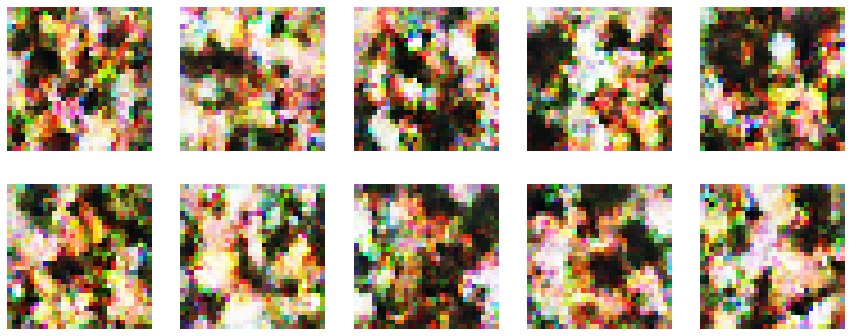

	log_pz = -1.3815
	log_d = 1461.2803
	log_pz = -1.3688
	log_d = 1616.8330
	log_pz = -1.4061
	log_d = 1766.6951
	log_pz = -1.4453
	log_d = 1761.6924
	log_pz = -1.4508
	log_d = 1663.2217
	log_pz = -1.4061
	log_d = 1558.1409
	log_pz = -1.3772
	log_d = 1694.7018
	log_pz = -1.3893
	log_d = 1376.0352
	log_pz = -1.3752
	log_d = 1703.7434
	log_pz = -1.4087
	log_d = 1651.0187
	log_pz = -1.4177
	log_d = 1727.3242
	log_pz = -1.4357
	log_d = 1828.2571
	log_pz = -1.4120
	log_d = 1811.2531
EPOCH : 1
	log_pz = -1.3884
	log_d = 1737.6914
	log_pz = -1.3993
	log_d = 1637.6680
	log_pz = -1.4064
	log_d = 1715.3940
	log_pz = -1.4123
	log_d = 1698.5392
	log_pz = -1.4128
	log_d = 1924.6779
	log_pz = -1.4131
	log_d = 1690.6746
	log_pz = -1.4019
	log_d = 1686.1228
	log_pz = -1.3942
	log_d = 1665.6503
	log_pz = -1.3909
	log_d = 1879.7517
	log_pz = -1.4379
	log_d = 1839.9673
	log_pz = -1.4106
	log_d = 1956.0271
	log_pz = -1.4176
	log_d = 1919.6938
	log_pz = -1.4417
	log_d = 1635.7288
	log_pz = -1.4133
	log_d = 1

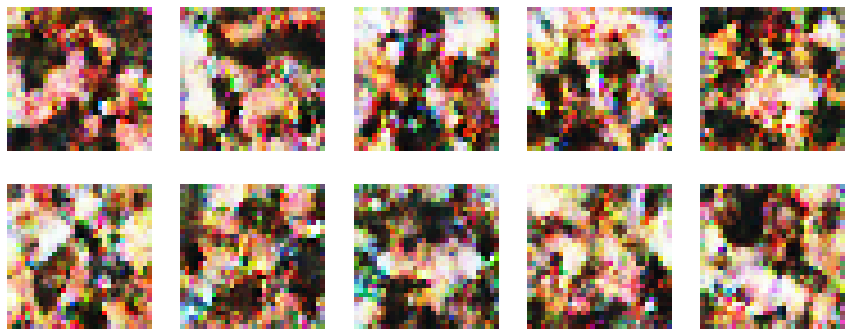

	log_pz = -1.4273
	log_d = 1833.2084
	log_pz = -1.4117
	log_d = 1987.6321
	log_pz = -1.4244
	log_d = 2193.6548
	log_pz = -1.4299
	log_d = 2091.7913
	log_pz = -1.4258
	log_d = 1778.5588
	log_pz = -1.3964
	log_d = 1770.2415
	log_pz = -1.4023
	log_d = 1879.8911
	log_pz = -1.4047
	log_d = 1719.1801
	log_pz = -1.4055
	log_d = 1767.1479
	log_pz = -1.3992
	log_d = 1716.8212
	log_pz = -1.3822
	log_d = 1769.8018
	log_pz = -1.3891
	log_d = 1949.4407
	log_pz = -1.4133
	log_d = 1946.5492
	log_pz = -1.4123
	log_d = 1765.0328
	log_pz = -1.4128
	log_d = 1888.9474
	log_pz = -1.4091
	log_d = 1919.3597
	log_pz = -1.4262
	log_d = 1799.4097
	log_pz = -1.4192
	log_d = 2144.4966
	log_pz = -1.4016
	log_d = 2085.6426
	log_pz = -1.4726
	log_d = 1777.7800
	log_pz = -1.4113
	log_d = 1718.6460
	log_pz = -1.4018
	log_d = 1950.3232
	log_pz = -1.4193
	log_d = 1713.7166
	log_pz = -1.3896
	log_d = 1772.6475
	log_pz = -1.3949
	log_d = 1830.6206
	log_pz = -1.4087
	log_d = 1949.7710
	log_pz = -1.4236
	log_d = 1848.8156
	

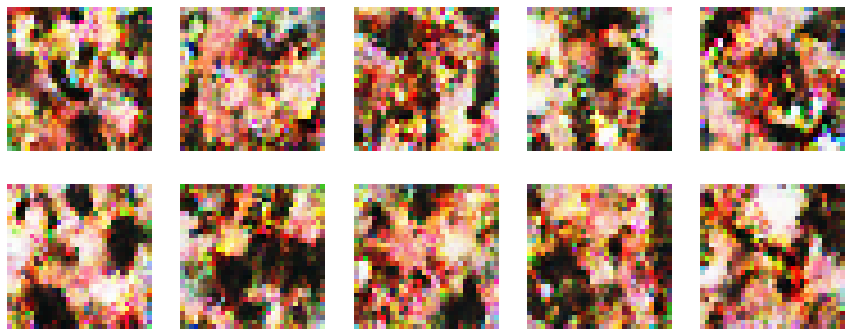

	log_pz = -1.4129
	log_d = 2002.8555
	log_pz = -1.4329
	log_d = 1980.0244
	log_pz = -1.4389
	log_d = 1746.5676
	log_pz = -1.4064
	log_d = 1867.9020
	log_pz = -1.3963
	log_d = 1999.3408
	log_pz = -1.4072
	log_d = 1806.3447
	log_pz = -1.3933
	log_d = 2096.4297
	log_pz = -1.4143
	log_d = 1908.1316
	log_pz = -1.4128
	log_d = 1888.4753
	log_pz = -1.4176
	log_d = 1549.9452
	log_pz = -1.4154
	log_d = 2192.9517
	log_pz = -1.4158
	log_d = 1798.1387
	log_pz = -1.3897
	log_d = 1893.7886
	log_pz = -1.3902
	log_d = 1997.8352
	log_pz = -1.3982
	log_d = 1886.3250
	log_pz = -1.4306
	log_d = 1914.0112
	log_pz = -1.4091
	log_d = 2210.8765
	log_pz = -1.3972
	log_d = 2022.4570
	log_pz = -1.4093
	log_d = 1964.8672
	log_pz = -1.4186
	log_d = 2019.9634
	log_pz = -1.4065
	log_d = 2101.1836
	log_pz = -1.4157
	log_d = 2108.0322
	log_pz = -1.4368
	log_d = 1951.7339
	log_pz = -1.4048
	log_d = 1853.4358
	log_pz = -1.3787
	log_d = 1979.0165
	log_pz = -1.4118
	log_d = 2149.7322
	log_pz = -1.4352
	log_d = 1916.6892
	

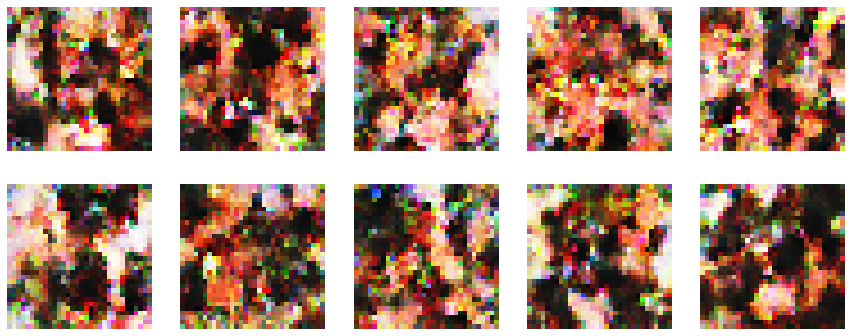

	log_pz = -1.4097
	log_d = 2197.4023
	log_pz = -1.4365
	log_d = 1959.5713
	log_pz = -1.4224
	log_d = 1920.7053
	log_pz = -1.4040
	log_d = 1966.1392
	log_pz = -1.3822
	log_d = 2096.9863
	log_pz = -1.3887
	log_d = 2143.5994
	log_pz = -1.4151
	log_d = 1910.1663
	log_pz = -1.4078
	log_d = 1962.5173
	log_pz = -1.4193
	log_d = 2032.0323
	log_pz = -1.4113
	log_d = 2121.1978
	log_pz = -1.3950
	log_d = 1884.3497
	log_pz = -1.3894
	log_d = 2003.4966
	log_pz = -1.3987
	log_d = 2145.7629
	log_pz = -1.4165
	log_d = 2201.5090
	log_pz = -1.4461
	log_d = 2016.4614
	log_pz = -1.3940
	log_d = 2123.7195
	log_pz = -1.4420
	log_d = 1964.6105
	log_pz = -1.4506
	log_d = 2093.7246
	log_pz = -1.3968
	log_d = 1926.4590
	log_pz = -1.3811
	log_d = 1886.0562
	log_pz = -1.3935
	log_d = 1985.7009
	log_pz = -1.4255
	log_d = 1944.4312
	log_pz = -1.3917
	log_d = 1966.1890
	log_pz = -1.4022
	log_d = 1849.3093
	log_pz = -1.3943
	log_d = 2406.9895
	log_pz = -1.4268
	log_d = 2399.4736
	log_pz = -1.4364
	log_d = 2064.9343
	

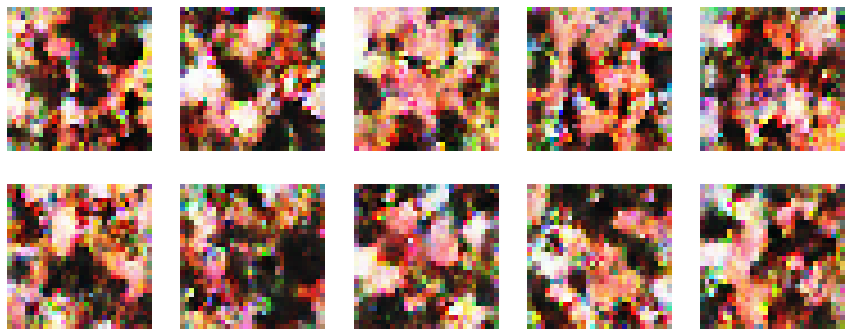

	log_pz = -1.4197
	log_d = 2184.7979
	log_pz = -1.4254
	log_d = 2182.2375
	log_pz = -1.4035
	log_d = 2102.3767
	log_pz = -1.3912
	log_d = 2032.5056
	log_pz = -1.4042
	log_d = 2014.3516
	log_pz = -1.3997
	log_d = 2085.2537
	log_pz = -1.3994
	log_d = 2224.4888
	log_pz = -1.4168
	log_d = 2112.3379
	log_pz = -1.4127
	log_d = 2299.9766
	log_pz = -1.4121
	log_d = 2407.0862
	log_pz = -1.4293
	log_d = 1936.5320
	log_pz = -1.4192
	log_d = 2018.7131
	log_pz = -1.4223
	log_d = 2092.5137
	log_pz = -1.3995
	log_d = 2146.0437
	log_pz = -1.3986
	log_d = 2283.7573
	log_pz = -1.3924
	log_d = 2222.0527
	log_pz = -1.4269
	log_d = 2129.1880
	log_pz = -1.4005
	log_d = 2392.3940
	log_pz = -1.4110
	log_d = 2109.9502
	log_pz = -1.5038
	log_d = 2184.5420
	log_pz = -1.4130
	log_d = 2027.6655
	log_pz = -1.3848
	log_d = 1956.7209
	log_pz = -1.3975
	log_d = 2190.7227
	log_pz = -1.4429
	log_d = 2091.3020
	log_pz = -1.4196
	log_d = 2089.9668
	log_pz = -1.4070
	log_d = 2002.3906
	log_pz = -1.4082
	log_d = 1886.8716
	

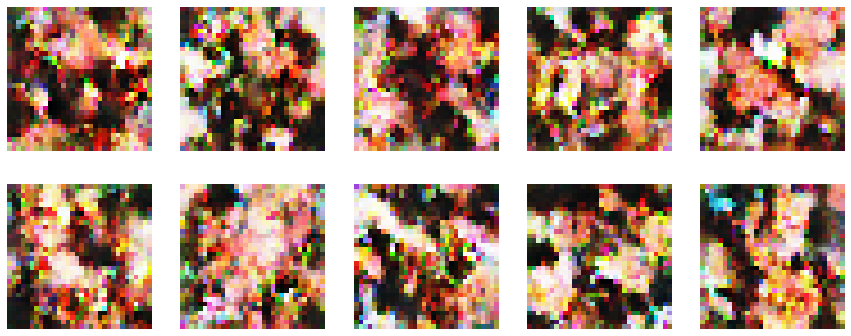

	log_pz = -1.4118
	log_d = 2069.9854
	log_pz = -1.4079
	log_d = 2318.4521
	log_pz = -1.4091
	log_d = 2386.7114
	log_pz = -1.4183
	log_d = 2323.1895
	log_pz = -1.4229
	log_d = 2203.7451
	log_pz = -1.4116
	log_d = 2461.1235
	log_pz = -1.4113
	log_d = 2373.3259
	log_pz = -1.4217
	log_d = 2237.2295
	log_pz = -1.3972
	log_d = 2060.6514
	log_pz = -1.3812
	log_d = 2368.2422
	log_pz = -1.3786
	log_d = 2217.9446
	log_pz = -1.4063
	log_d = 2498.9961
	log_pz = -1.3951
	log_d = 2332.1292
	log_pz = -1.4316
	log_d = 2401.5850
	log_pz = -1.4118
	log_d = 2348.5332
	log_pz = -1.4312
	log_d = 2120.3611
	log_pz = -1.4069
	log_d = 2414.1772
	log_pz = -1.4074
	log_d = 2094.2310
	log_pz = -1.4047
	log_d = 2222.3145
	log_pz = -1.3970
	log_d = 2390.1025
	log_pz = -1.4295
	log_d = 2231.0645
	log_pz = -1.3908
	log_d = 2271.5312
	log_pz = -1.4007
	log_d = 2094.7175
	log_pz = -1.4204
	log_d = 2037.2982
	log_pz = -1.4157
	log_d = 2520.7820
	log_pz = -1.4255
	log_d = 2131.8940
	log_pz = -1.4159
	log_d = 1975.2780
	

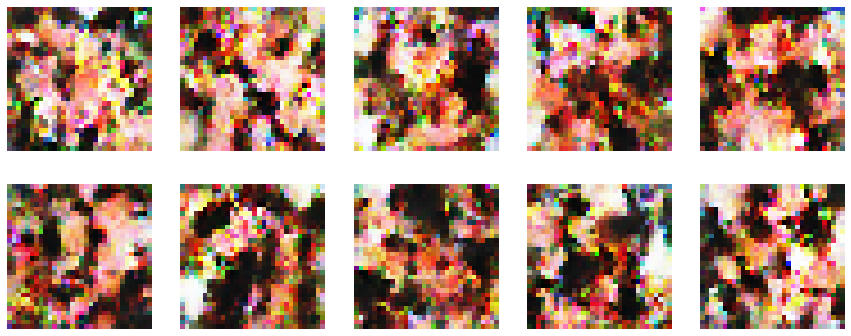

	log_pz = -1.4084
	log_d = 2227.3352
	log_pz = -1.3969
	log_d = 2296.2847
	log_pz = -1.4262
	log_d = 2266.7615
	log_pz = -1.3988
	log_d = 2416.7222
	log_pz = -1.4324
	log_d = 2145.7734
	log_pz = -1.4108
	log_d = 2285.3911
	log_pz = -1.4032
	log_d = 2274.1838
	log_pz = -1.4067
	log_d = 2395.9141
	log_pz = -1.4277
	log_d = 2374.8774
	log_pz = -1.3889
	log_d = 2308.7358
	log_pz = -1.3848
	log_d = 2295.7275
	log_pz = -1.4214
	log_d = 2152.7578
	log_pz = -1.4160
	log_d = 2475.2832
EPOCH : 2
	log_pz = -1.4032
	log_d = 2326.1169
	log_pz = -1.3871
	log_d = 2302.0183
	log_pz = -1.4112
	log_d = 2347.8154
	log_pz = -1.4029
	log_d = 2333.7554
	log_pz = -1.4157
	log_d = 2172.7563
	log_pz = -1.4082
	log_d = 2235.4302
	log_pz = -1.4034
	log_d = 2227.6794
	log_pz = -1.4210
	log_d = 2368.5137
	log_pz = -1.4274
	log_d = 2297.9136
	log_pz = -1.4235
	log_d = 2194.3179
	log_pz = -1.3971
	log_d = 2405.2119
	log_pz = -1.3839
	log_d = 2322.8818
	log_pz = -1.4028
	log_d = 2000.6747
	log_pz = -1.4153
	log_d = 2

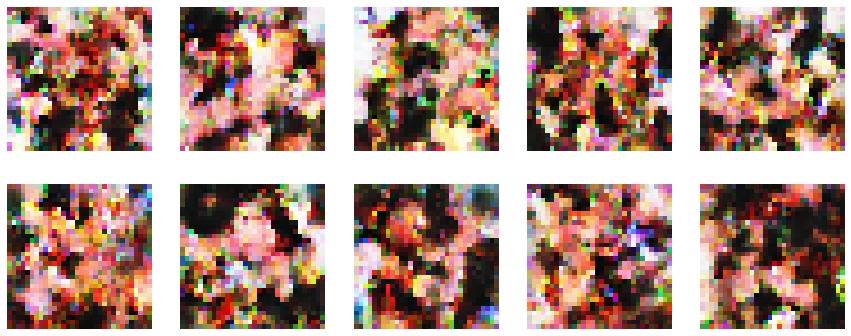

	log_pz = -1.4098
	log_d = 2284.6792
	log_pz = -1.4083
	log_d = 2219.8315
	log_pz = -1.4054
	log_d = 2323.5513
	log_pz = -1.4047
	log_d = 2388.3562
	log_pz = -1.4078
	log_d = 2498.9639
	log_pz = -1.4042
	log_d = 2613.8918
	log_pz = -1.4001
	log_d = 2451.4475
	log_pz = -1.4125
	log_d = 2384.0620
	log_pz = -1.3996
	log_d = 2620.3545
	log_pz = -1.4415
	log_d = 2406.2581
	log_pz = -1.3988
	log_d = 2286.5781
	log_pz = -1.4032
	log_d = 2348.6323
	log_pz = -1.4385
	log_d = 2299.8665
	log_pz = -1.4464
	log_d = 2280.3779
	log_pz = -1.3830
	log_d = 2132.3938
	log_pz = -1.3795
	log_d = 2289.1946
	log_pz = -1.3905
	log_d = 2202.6846
	log_pz = -1.4017
	log_d = 2398.1787
	log_pz = -1.3875
	log_d = 2629.2275
	log_pz = -1.4146
	log_d = 2206.2566
	log_pz = -1.4132
	log_d = 2322.6494
	log_pz = -1.4175
	log_d = 2401.4951
	log_pz = -1.4178
	log_d = 2382.2178
	log_pz = -1.3988
	log_d = 2163.6577
	log_pz = -1.3894
	log_d = 2552.6870
	log_pz = -1.3983
	log_d = 2366.5994
	log_pz = -1.4255
	log_d = 2196.0410
	

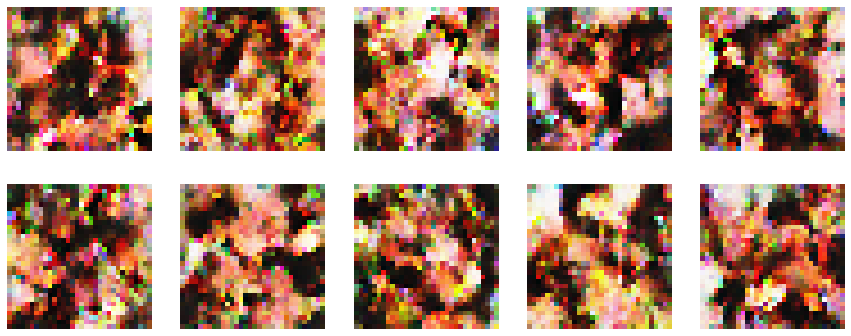

	log_pz = -1.4119
	log_d = 2372.6436
	log_pz = -1.4192
	log_d = 2349.1638
	log_pz = -1.4029
	log_d = 2233.1765
	log_pz = -1.3901
	log_d = 2271.1738
	log_pz = -1.3847
	log_d = 2527.1863
	log_pz = -1.4141
	log_d = 2708.9067
	log_pz = -1.4249
	log_d = 2393.3403
	log_pz = -1.4204
	log_d = 2509.5337
	log_pz = -1.4304
	log_d = 2431.5020
	log_pz = -1.4037
	log_d = 2404.8472
	log_pz = -1.3814
	log_d = 2304.7456
	log_pz = -1.3876
	log_d = 2348.5017
	log_pz = -1.3973
	log_d = 2465.0342
	log_pz = -1.4137
	log_d = 2418.3115
	log_pz = -1.4251
	log_d = 2396.5063
	log_pz = -1.4467
	log_d = 2424.1321
	log_pz = -1.4326
	log_d = 2289.1199
	log_pz = -1.3890
	log_d = 2363.9346
	log_pz = -1.4081
	log_d = 2282.1099
	log_pz = -1.3797
	log_d = 2275.6689
	log_pz = -1.3842
	log_d = 2229.4246
	log_pz = -1.3860
	log_d = 2337.0339
	log_pz = -1.4189
	log_d = 2347.6660
	log_pz = -1.4012
	log_d = 2613.7200
	log_pz = -1.3972
	log_d = 2418.6870
	log_pz = -1.4181
	log_d = 2731.2817
	log_pz = -1.4262
	log_d = 2581.7476
	

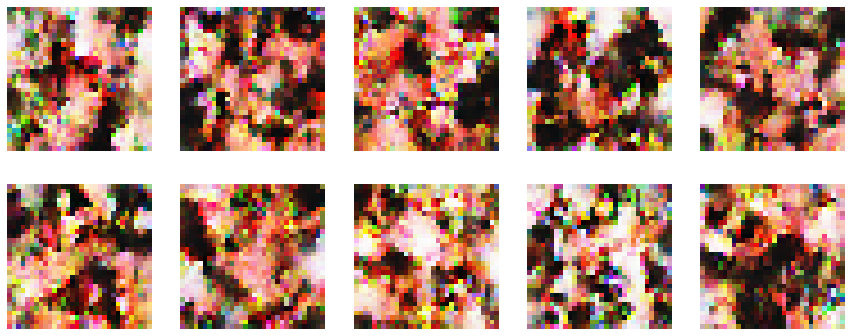

	log_pz = -1.4066
	log_d = 2464.3540
	log_pz = -1.4252
	log_d = 2596.6724
	log_pz = -1.4047
	log_d = 2595.7908
	log_pz = -1.4526
	log_d = 2669.0073
	log_pz = -1.4189
	log_d = 2256.5535
	log_pz = -1.4005
	log_d = 2436.0352
	log_pz = -1.3996
	log_d = 2335.0945
	log_pz = -1.4061
	log_d = 2500.5801
	log_pz = -1.3968
	log_d = 2580.3333
	log_pz = -1.4076
	log_d = 2415.2412
	log_pz = -1.4017
	log_d = 2256.3357
	log_pz = -1.4121
	log_d = 2373.8613
	log_pz = -1.4313
	log_d = 2369.5383
	log_pz = -1.4044
	log_d = 2705.2363
	log_pz = -1.4173
	log_d = 2324.4126
	log_pz = -1.4003
	log_d = 2614.3706
	log_pz = -1.4006
	log_d = 2446.4426
	log_pz = -1.4027
	log_d = 2461.4006
	log_pz = -1.3988
	log_d = 2314.9607
	log_pz = -1.4215
	log_d = 2298.9580
	log_pz = -1.4113
	log_d = 2392.0420
	log_pz = -1.4126
	log_d = 2412.5181
	log_pz = -1.4098
	log_d = 2528.0269
	log_pz = -1.4147
	log_d = 2563.7256
	log_pz = -1.3916
	log_d = 2636.1130
	log_pz = -1.4132
	log_d = 2385.1377
	log_pz = -1.4063
	log_d = 2427.2112
	

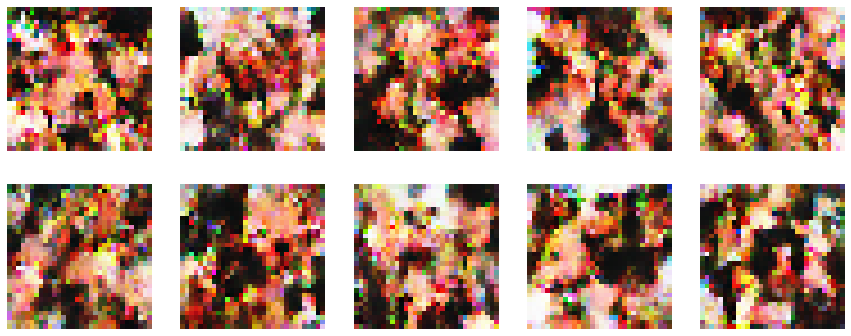

	log_pz = -1.3998
	log_d = 2663.3022
	log_pz = -1.4162
	log_d = 2640.8193
	log_pz = -1.4034
	log_d = 2596.6238
	log_pz = -1.3916
	log_d = 2704.7368
	log_pz = -1.3986
	log_d = 2548.1431
	log_pz = -1.4207
	log_d = 2589.5586
	log_pz = -1.4033
	log_d = 2517.5044
	log_pz = -1.4136
	log_d = 2383.2896
	log_pz = -1.4138
	log_d = 2598.7861
	log_pz = -1.4115
	log_d = 2374.0474
	log_pz = -1.3759
	log_d = 2640.9634
	log_pz = -1.4020
	log_d = 2510.1016
	log_pz = -1.4241
	log_d = 2587.9675
	log_pz = -1.4178
	log_d = 2553.5896
	log_pz = -1.4202
	log_d = 2712.4407
	log_pz = -1.4242
	log_d = 2437.6663
	log_pz = -1.3958
	log_d = 2343.7339
	log_pz = -1.4131
	log_d = 2503.7161
	log_pz = -1.4402
	log_d = 2632.3970
	log_pz = -1.3879
	log_d = 2472.4507
	log_pz = -1.4336
	log_d = 2420.2026
	log_pz = -1.4818
	log_d = 2707.2769
	log_pz = -1.4448
	log_d = 2375.7080
	log_pz = -1.3677
	log_d = 2494.6938
	log_pz = -1.3734
	log_d = 2182.1602
	log_pz = -1.3819
	log_d = 2292.3384
	log_pz = -1.4082
	log_d = 2476.7988
	

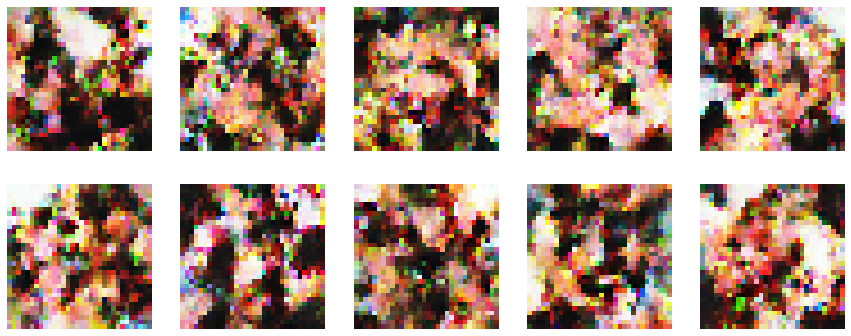

	log_pz = -1.4033
	log_d = 2742.4766
	log_pz = -1.4092
	log_d = 2573.7104
	log_pz = -1.4034
	log_d = 2518.8394
	log_pz = -1.3878
	log_d = 2604.1104
	log_pz = -1.4042
	log_d = 2388.0984
	log_pz = -1.4002
	log_d = 2774.2400
	log_pz = -1.3997
	log_d = 2504.7129
	log_pz = -1.3830
	log_d = 2829.3892
	log_pz = -1.4199
	log_d = 2563.0039
	log_pz = -1.4256
	log_d = 2382.4336
	log_pz = -1.4109
	log_d = 2415.5928
	log_pz = -1.3932
	log_d = 2539.8281
	log_pz = -1.3931
	log_d = 2584.6465
	log_pz = -1.4114
	log_d = 2561.2207
	log_pz = -1.4134
	log_d = 2616.3472
	log_pz = -1.4060
	log_d = 2669.7329
	log_pz = -1.3948
	log_d = 2782.9268
	log_pz = -1.4351
	log_d = 2458.6206
	log_pz = -1.4272
	log_d = 2650.3604
	log_pz = -1.3932
	log_d = 2531.6284
	log_pz = -1.3969
	log_d = 2590.4395
	log_pz = -1.4224
	log_d = 2492.8066
	log_pz = -1.3853
	log_d = 2684.3076
	log_pz = -1.4042
	log_d = 2600.8965
	log_pz = -1.4372
	log_d = 2434.8652
	log_pz = -1.4098
	log_d = 2359.9436
	log_pz = -1.4204
	log_d = 2502.8081
	

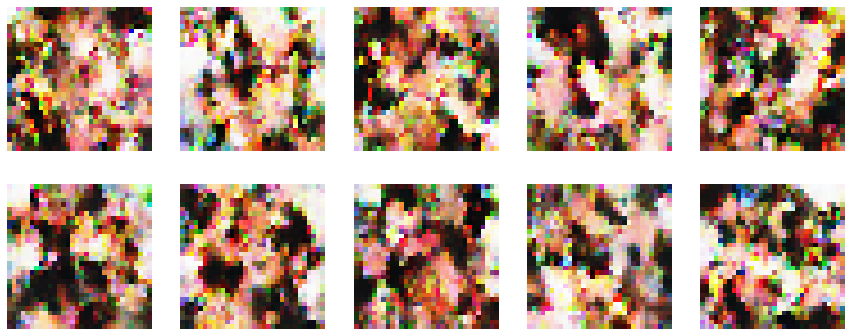

	log_pz = -1.4526
	log_d = 2499.4971
	log_pz = -1.4249
	log_d = 2463.7466
	log_pz = -1.4357
	log_d = 2612.9700
	log_pz = -1.4032
	log_d = 2544.3975
	log_pz = -1.3755
	log_d = 2568.5894
	log_pz = -1.3814
	log_d = 2476.9097
	log_pz = -1.4439
	log_d = 2529.5442
	log_pz = -1.4244
	log_d = 2626.6670
	log_pz = -1.4132
	log_d = 2499.3323
	log_pz = -1.4028
	log_d = 2626.2903
	log_pz = -1.4195
	log_d = 2613.7314
	log_pz = -1.4296
	log_d = 2730.3931
	log_pz = -1.4243
	log_d = 2679.1003
EPOCH : 3
	log_pz = -1.4379
	log_d = 2330.7739
	log_pz = -1.4066
	log_d = 2505.8711
	log_pz = -1.4107
	log_d = 2623.8457
	log_pz = -1.4029
	log_d = 2384.6523
	log_pz = -1.4062
	log_d = 2627.9180
	log_pz = -1.3916
	log_d = 2582.3562
	log_pz = -1.4070
	log_d = 2253.1414
	log_pz = -1.3814
	log_d = 2503.2188
	log_pz = -1.3930
	log_d = 2538.1279
	log_pz = -1.4210
	log_d = 2692.7676
	log_pz = -1.4333
	log_d = 2499.9451
	log_pz = -1.3983
	log_d = 2700.3145
	log_pz = -1.4140
	log_d = 2532.3193
	log_pz = -1.4214
	log_d = 2

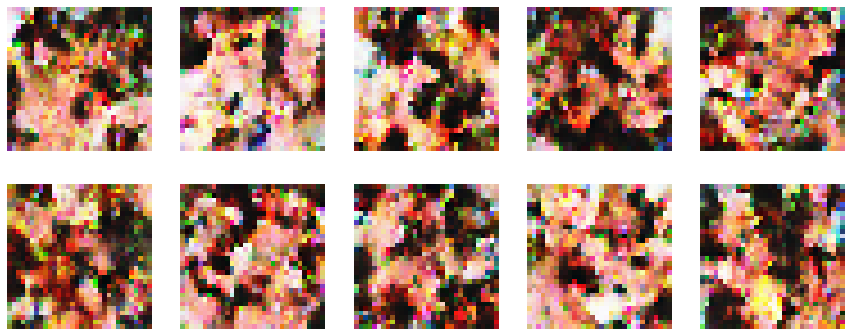

	log_pz = -1.4110
	log_d = 2644.9888
	log_pz = -1.4132
	log_d = 2676.9312
	log_pz = -1.4062
	log_d = 2761.4434
	log_pz = -1.4006
	log_d = 2655.0723
	log_pz = -1.3953
	log_d = 2707.0874
	log_pz = -1.4013
	log_d = 2657.2124
	log_pz = -1.4018
	log_d = 2624.2373
	log_pz = -1.3866
	log_d = 2656.5732
	log_pz = -1.4064
	log_d = 2725.1157
	log_pz = -1.4120
	log_d = 2750.1641
	log_pz = -1.4043
	log_d = 2765.7031
	log_pz = -1.4075
	log_d = 2589.6787
	log_pz = -1.4086
	log_d = 2700.3550
	log_pz = -1.3962
	log_d = 2677.3188
	log_pz = -1.4061
	log_d = 2578.6965
	log_pz = -1.4235
	log_d = 2380.5969
	log_pz = -1.3884
	log_d = 2838.0288
	log_pz = -1.4003
	log_d = 2685.8394
	log_pz = -1.4073
	log_d = 2786.8223
	log_pz = -1.3981
	log_d = 2831.9722
	log_pz = -1.4018
	log_d = 2799.7048
	log_pz = -1.4111
	log_d = 2715.1060
	log_pz = -1.4125
	log_d = 2608.7661
	log_pz = -1.4168
	log_d = 2616.2134
	log_pz = -1.4026
	log_d = 2817.3313
	log_pz = -1.4239
	log_d = 2561.0391
	log_pz = -1.4043
	log_d = 2580.4795
	

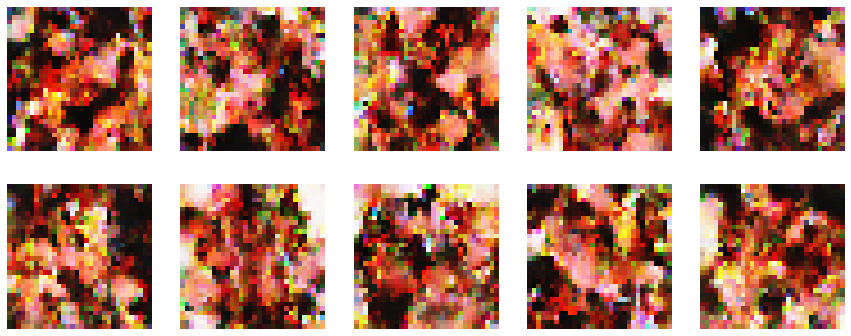

	log_pz = -1.4574
	log_d = 2451.3503
	log_pz = -1.4585
	log_d = 2800.0786
	log_pz = -1.3884
	log_d = 2488.5745
	log_pz = -1.3833
	log_d = 2424.9541
	log_pz = -1.3895
	log_d = 2283.8188
	log_pz = -1.3917
	log_d = 2489.1006
	log_pz = -1.3877
	log_d = 2549.4902
	log_pz = -1.3911
	log_d = 2614.4810
	log_pz = -1.4415
	log_d = 2627.0312
	log_pz = -1.4623
	log_d = 2670.5715
	log_pz = -1.4353
	log_d = 2530.7219
	log_pz = -1.4081
	log_d = 2667.3179
	log_pz = -1.3993
	log_d = 2529.5679
	log_pz = -1.3733
	log_d = 2516.4927
	log_pz = -1.3789
	log_d = 2459.3440
	log_pz = -1.3754
	log_d = 2566.3582
	log_pz = -1.3871
	log_d = 2640.6267
	log_pz = -1.4097
	log_d = 2686.4258
	log_pz = -1.4230
	log_d = 2837.4800
	log_pz = -1.4174
	log_d = 2464.7744
	log_pz = -1.4143
	log_d = 2521.8301
	log_pz = -1.4033
	log_d = 2733.1631
	log_pz = -1.4080
	log_d = 2798.1204
	log_pz = -1.3791
	log_d = 2847.7671
	log_pz = -1.4039
	log_d = 2408.5605
	log_pz = -1.3949
	log_d = 2626.2087
	log_pz = -1.4070
	log_d = 2714.8638
	

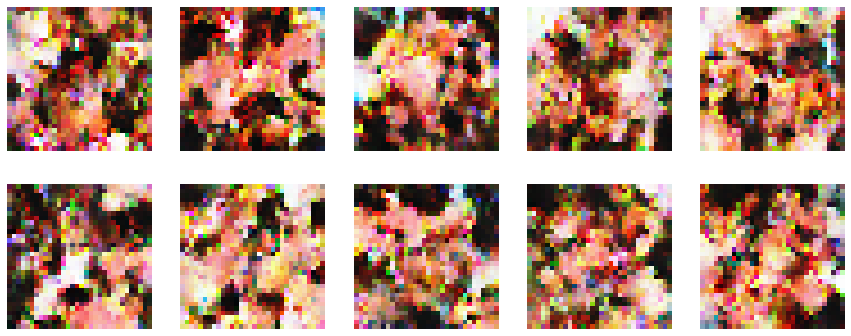

	log_pz = -1.3981
	log_d = 2684.2522
	log_pz = -1.4228
	log_d = 2911.4734
	log_pz = -1.4273
	log_d = 2601.0098
	log_pz = -1.4107
	log_d = 2624.1504
	log_pz = -1.3733
	log_d = 2657.3022
	log_pz = -1.3989
	log_d = 2768.8633
	log_pz = -1.4145
	log_d = 2721.6165
	log_pz = -1.3847
	log_d = 2796.5703
	log_pz = -1.3911
	log_d = 2967.2002
	log_pz = -1.4278
	log_d = 2785.9292
	log_pz = -1.4005
	log_d = 2965.8804
	log_pz = -1.4033
	log_d = 2913.3584
	log_pz = -1.4020
	log_d = 2850.9219
	log_pz = -1.3998
	log_d = 2762.1243
	log_pz = -1.4043
	log_d = 2954.8130
	log_pz = -1.3966
	log_d = 2776.4639
	log_pz = -1.4071
	log_d = 2609.6826
	log_pz = -1.4107
	log_d = 2964.7871
	log_pz = -1.4070
	log_d = 2949.4497
	log_pz = -1.3996
	log_d = 2732.4775
	log_pz = -1.3864
	log_d = 2842.1545
	log_pz = -1.4032
	log_d = 2682.6646
	log_pz = -1.4034
	log_d = 2765.3032
	log_pz = -1.4281
	log_d = 2874.2505
	log_pz = -1.4018
	log_d = 2653.3010
	log_pz = -1.4033
	log_d = 3047.0911
	log_pz = -1.4449
	log_d = 2745.2444
	

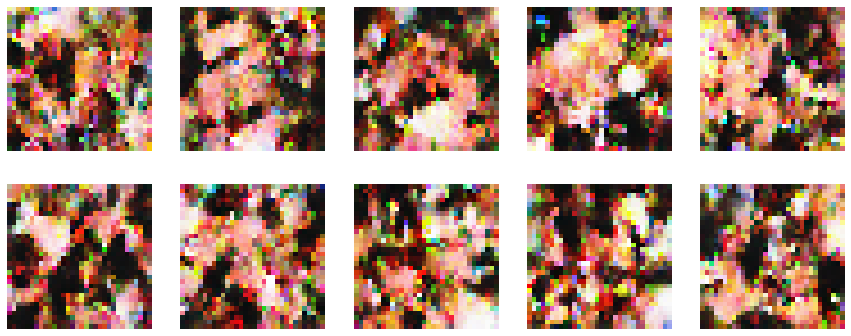

	log_pz = -1.4182
	log_d = 2792.4280
	log_pz = -1.4041
	log_d = 2722.3801
	log_pz = -1.4011
	log_d = 2842.9644
	log_pz = -1.3995
	log_d = 2698.1953
	log_pz = -1.3845
	log_d = 2624.7383
	log_pz = -1.3782
	log_d = 2831.0859
	log_pz = -1.4000
	log_d = 2832.5103
	log_pz = -1.4031
	log_d = 2785.5671
	log_pz = -1.4351
	log_d = 2740.3130
	log_pz = -1.4165
	log_d = 2684.0947
	log_pz = -1.3964
	log_d = 2977.5845
	log_pz = -1.4284
	log_d = 2733.6865
	log_pz = -1.3996
	log_d = 2734.8877
	log_pz = -1.3783
	log_d = 2952.0728
	log_pz = -1.3909
	log_d = 2888.7290
	log_pz = -1.4018
	log_d = 2747.5410
	log_pz = -1.3993
	log_d = 2859.7998
	log_pz = -1.3970
	log_d = 2863.8740
	log_pz = -1.4253
	log_d = 2937.5940
	log_pz = -1.4147
	log_d = 2784.7373
	log_pz = -1.3954
	log_d = 2919.2036
	log_pz = -1.4095
	log_d = 2786.9048
	log_pz = -1.3916
	log_d = 2691.1472
	log_pz = -1.3961
	log_d = 2724.6626
	log_pz = -1.4172
	log_d = 2932.9121
	log_pz = -1.4070
	log_d = 2796.9863
	log_pz = -1.4125
	log_d = 2713.5249
	

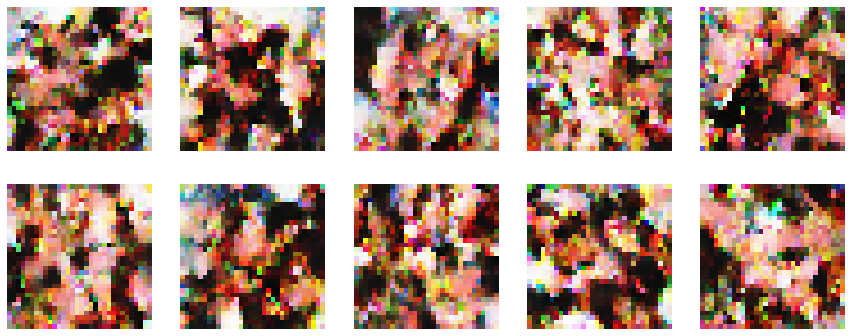

	log_pz = -1.4039
	log_d = 2909.6147
	log_pz = -1.4102
	log_d = 2911.2856
	log_pz = -1.4190
	log_d = 2699.9165
	log_pz = -1.3935
	log_d = 3185.4841
	log_pz = -1.4017
	log_d = 2664.1958
	log_pz = -1.3807
	log_d = 2853.9297
	log_pz = -1.3851
	log_d = 2877.8145
	log_pz = -1.4009
	log_d = 3096.0154
	log_pz = -1.4278
	log_d = 2759.0259
	log_pz = -1.4368
	log_d = 2887.6685
	log_pz = -1.4015
	log_d = 3040.8496
	log_pz = -1.3846
	log_d = 3154.7905
	log_pz = -1.4035
	log_d = 2854.4771
	log_pz = -1.4114
	log_d = 3034.0325
	log_pz = -1.4620
	log_d = 2697.0273
	log_pz = -1.5628
	log_d = 2571.9551
	log_pz = -1.6161
	log_d = 2652.7437
	log_pz = -1.4394
	log_d = 2459.8950
	log_pz = -1.3590
	log_d = 2134.5840
	log_pz = -1.3096
	log_d = 2156.2134
	log_pz = -1.3369
	log_d = 2164.8142
	log_pz = -1.3526
	log_d = 2327.7651
	log_pz = -1.4044
	log_d = 2575.1982
	log_pz = -1.4507
	log_d = 2805.1050
	log_pz = -1.4376
	log_d = 2588.4714
	log_pz = -1.4712
	log_d = 2604.5513
	log_pz = -1.4412
	log_d = 2598.1189
	

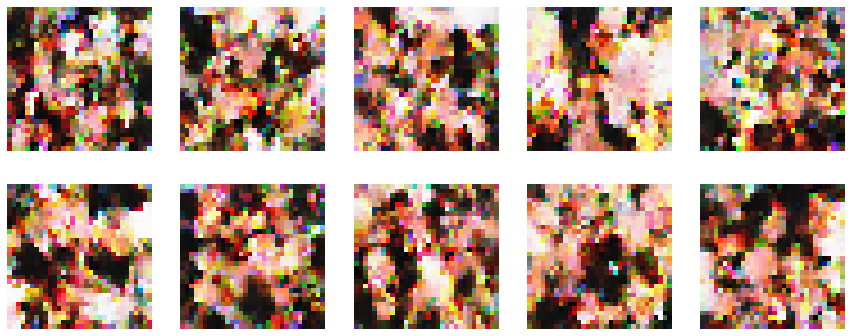

	log_pz = -1.4052
	log_d = 2795.2275
	log_pz = -1.3905
	log_d = 2891.0586
	log_pz = -1.3961
	log_d = 2703.6255
	log_pz = -1.4107
	log_d = 2755.4309
	log_pz = -1.3980
	log_d = 2899.6387
	log_pz = -1.4337
	log_d = 2707.6907
	log_pz = -1.4067
	log_d = 2937.1658
	log_pz = -1.4024
	log_d = 2779.7412
	log_pz = -1.3938
	log_d = 2592.5312
	log_pz = -1.3760
	log_d = 2675.7180
	log_pz = -1.3792
	log_d = 2906.1709
	log_pz = -1.4074
	log_d = 2970.7861
	log_pz = -1.3926
	log_d = 3152.2217
EPOCH : 4
	log_pz = -1.4083
	log_d = 2995.9648
	log_pz = -1.4156
	log_d = 2808.5032
	log_pz = -1.4187
	log_d = 2994.7607
	log_pz = -1.4164
	log_d = 2810.6140
	log_pz = -1.3856
	log_d = 2909.9077
	log_pz = -1.3937
	log_d = 2634.1387
	log_pz = -1.3951
	log_d = 2669.1782
	log_pz = -1.3845
	log_d = 2749.1086
	log_pz = -1.3952
	log_d = 2692.9478
	log_pz = -1.3896
	log_d = 3035.8005
	log_pz = -1.3969
	log_d = 2959.4111
	log_pz = -1.4174
	log_d = 3069.8330
	log_pz = -1.4120
	log_d = 2748.9570
	log_pz = -1.3937
	log_d = 2

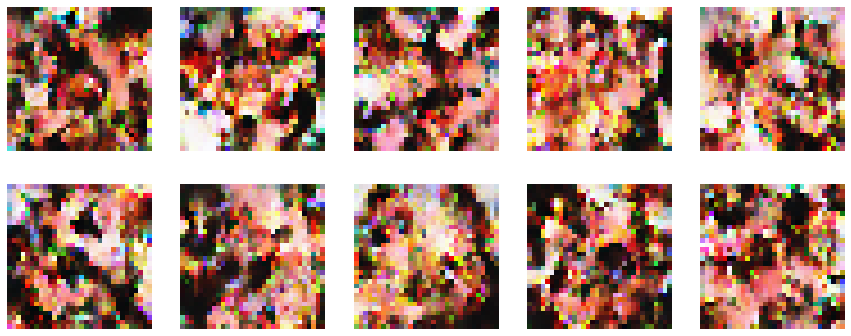

	log_pz = -1.3920
	log_d = 2882.0449
	log_pz = -1.4131
	log_d = 2658.8979
	log_pz = -1.3911
	log_d = 3010.1665
	log_pz = -1.4097
	log_d = 2905.9546
	log_pz = -1.4058
	log_d = 2748.2178
	log_pz = -1.4002
	log_d = 2828.4836
	log_pz = -1.3970
	log_d = 2908.4229
	log_pz = -1.3993
	log_d = 2770.6926
	log_pz = -1.4015
	log_d = 2912.0063
	log_pz = -1.3986
	log_d = 3046.6997
	log_pz = -1.3950
	log_d = 3076.0527
	log_pz = -1.4209
	log_d = 3012.8242
	log_pz = -1.4200
	log_d = 2843.7383
	log_pz = -1.3897
	log_d = 2918.4968
	log_pz = -1.3868
	log_d = 2717.0054
	log_pz = -1.3979
	log_d = 2721.3613
	log_pz = -1.4103
	log_d = 2795.9910
	log_pz = -1.4062
	log_d = 2860.7559
	log_pz = -1.4113
	log_d = 3103.0000
	log_pz = -1.4176
	log_d = 3034.5073
	log_pz = -1.3985
	log_d = 3061.3928
	log_pz = -1.3978
	log_d = 2677.2324
	log_pz = -1.3833
	log_d = 3017.8237
	log_pz = -1.3934
	log_d = 3252.8901
	log_pz = -1.3946
	log_d = 3210.4111
	log_pz = -1.4218
	log_d = 2877.6299
	log_pz = -1.4412
	log_d = 2964.0034
	

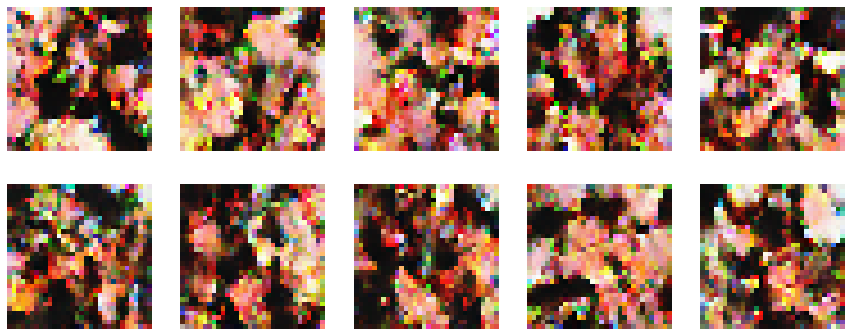

	log_pz = -1.3969
	log_d = 2882.3838
	log_pz = -1.4010
	log_d = 2788.9844
	log_pz = -1.3880
	log_d = 2935.0732
	log_pz = -1.4143
	log_d = 2693.9585
	log_pz = -1.4023
	log_d = 3055.4043
	log_pz = -1.3977
	log_d = 2909.3672
	log_pz = -1.4052
	log_d = 2678.2910
	log_pz = -1.4046
	log_d = 2821.8640
	log_pz = -1.4044
	log_d = 2963.9316
	log_pz = -1.3895
	log_d = 3244.6362
	log_pz = -1.3926
	log_d = 2766.8340
	log_pz = -1.3909
	log_d = 2921.8726
	log_pz = -1.4053
	log_d = 3071.8916
	log_pz = -1.4054
	log_d = 2925.3086
	log_pz = -1.4278
	log_d = 3056.1196
	log_pz = -1.4131
	log_d = 2974.0359
	log_pz = -1.3953
	log_d = 2833.0293
	log_pz = -1.3971
	log_d = 2910.4209
	log_pz = -1.4084
	log_d = 2835.0361
	log_pz = -1.4071
	log_d = 2875.6919
	log_pz = -1.4363
	log_d = 2951.5601
	log_pz = -1.4404
	log_d = 2702.6636
	log_pz = -1.3852
	log_d = 3004.5339
	log_pz = -1.4073
	log_d = 2925.5728
	log_pz = -1.3907
	log_d = 2665.5688
	log_pz = -1.4313
	log_d = 2753.1670
	log_pz = -1.4048
	log_d = 2820.8782
	

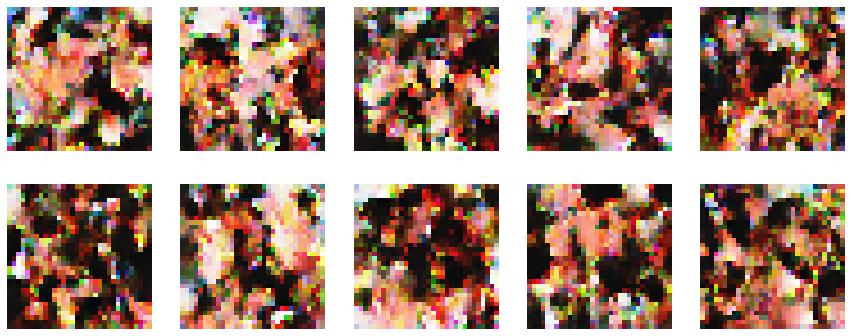

	log_pz = -1.3986
	log_d = 3043.6567
	log_pz = -1.3986
	log_d = 3093.6909
	log_pz = -1.4140
	log_d = 3060.0864
	log_pz = -1.4051
	log_d = 3136.4148
	log_pz = -1.4163
	log_d = 2959.5935
	log_pz = -1.3822
	log_d = 3008.7410
	log_pz = -1.4013
	log_d = 2740.7578
	log_pz = -1.3958
	log_d = 2913.1270
	log_pz = -1.3944
	log_d = 3229.4475
	log_pz = -1.3845
	log_d = 3098.6362
	log_pz = -1.4538
	log_d = 2922.7505
	log_pz = -1.4400
	log_d = 3132.0781
	log_pz = -1.4086
	log_d = 3046.6250
	log_pz = -1.3870
	log_d = 2980.7434
	log_pz = -1.4048
	log_d = 2953.6055
	log_pz = -1.4569
	log_d = 2737.2102
	log_pz = -1.4089
	log_d = 2944.3867
	log_pz = -1.4126
	log_d = 2736.6567
	log_pz = -1.4109
	log_d = 2651.6699
	log_pz = -1.4540
	log_d = 2717.9180
	log_pz = -1.4911
	log_d = 3110.4790
	log_pz = -1.4598
	log_d = 2743.8835
	log_pz = -1.4282
	log_d = 2792.2883
	log_pz = -1.4185
	log_d = 2581.2261
	log_pz = -1.4221
	log_d = 2858.7627
	log_pz = -1.5579
	log_d = 2933.6743
	log_pz = -1.5061
	log_d = 2620.6729
	

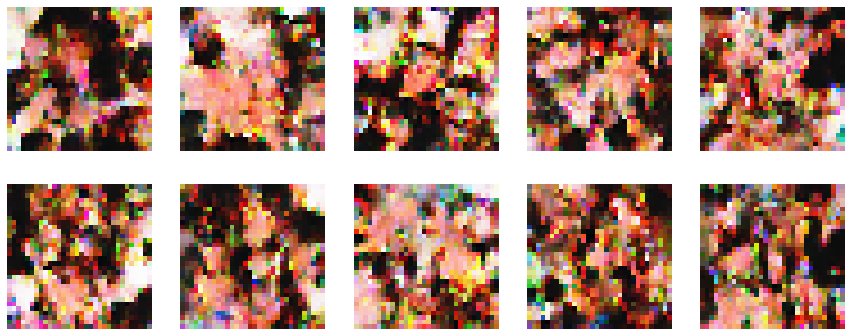

	log_pz = -1.3949
	log_d = 3033.9409
	log_pz = -1.3993
	log_d = 3002.4111
	log_pz = -1.4069
	log_d = 2836.9590
	log_pz = -1.3960
	log_d = 2967.1792
	log_pz = -1.3998
	log_d = 2940.1382
	log_pz = -1.4061
	log_d = 2831.3203
	log_pz = -1.3943
	log_d = 3044.8530
	log_pz = -1.3840
	log_d = 2952.3533
	log_pz = -1.3926
	log_d = 3005.3914
	log_pz = -1.3974
	log_d = 3017.1851
	log_pz = -1.3990
	log_d = 2893.7764
	log_pz = -1.3958
	log_d = 3218.7734
	log_pz = -1.4029
	log_d = 2937.8899
	log_pz = -1.4000
	log_d = 2983.6875
	log_pz = -1.3878
	log_d = 3097.4055
	log_pz = -1.3922
	log_d = 2991.9436
	log_pz = -1.3893
	log_d = 3020.4580
	log_pz = -1.3958
	log_d = 2883.2100
	log_pz = -1.3942
	log_d = 3112.3530
	log_pz = -1.4043
	log_d = 2810.5601
	log_pz = -1.3906
	log_d = 3061.8931
	log_pz = -1.4087
	log_d = 2845.1936
	log_pz = -1.3859
	log_d = 3266.5225
	log_pz = -1.3913
	log_d = 3060.0435
	log_pz = -1.3894
	log_d = 3236.0540
	log_pz = -1.4169
	log_d = 3092.0674
	log_pz = -1.4084
	log_d = 2852.7822
	

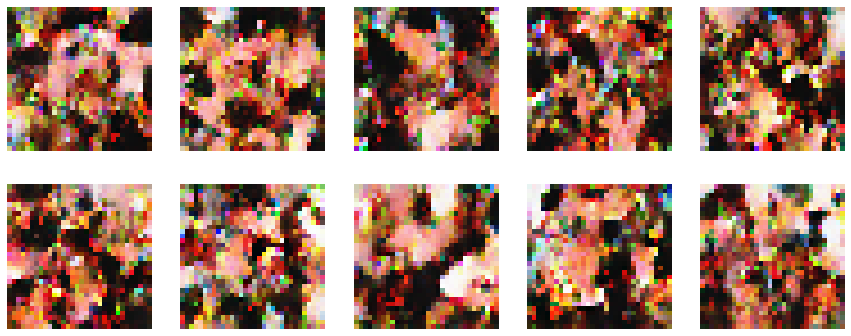

	log_pz = -1.3961
	log_d = 2961.2197
	log_pz = -1.3903
	log_d = 3000.4146
	log_pz = -1.3788
	log_d = 3242.2507
	log_pz = -1.4035
	log_d = 3006.8923
	log_pz = -1.3998
	log_d = 3120.7725
	log_pz = -1.4114
	log_d = 3052.8501
	log_pz = -1.4189
	log_d = 2991.4641
	log_pz = -1.4028
	log_d = 3050.4917
	log_pz = -1.3979
	log_d = 3149.7686
	log_pz = -1.4038
	log_d = 3018.2427
	log_pz = -1.4198
	log_d = 2913.4639
	log_pz = -1.4325
	log_d = 3132.8296
	log_pz = -1.4123
	log_d = 2882.5166
	log_pz = -1.4062
	log_d = 2942.8672
	log_pz = -1.4255
	log_d = 2875.4602
	log_pz = -1.3743
	log_d = 2817.2585
	log_pz = -1.3821
	log_d = 2906.6831
	log_pz = -1.4067
	log_d = 2967.0063
	log_pz = -1.4341
	log_d = 3023.2957
	log_pz = -1.4000
	log_d = 2808.9121
	log_pz = -1.4092
	log_d = 2994.3186
	log_pz = -1.4269
	log_d = 2938.7002
	log_pz = -1.4589
	log_d = 3263.4395
	log_pz = -1.4066
	log_d = 3086.5178
	log_pz = -1.3883
	log_d = 2982.7200
	log_pz = -1.4085
	log_d = 2782.4272
	log_pz = -1.3993
	log_d = 3154.1602
	

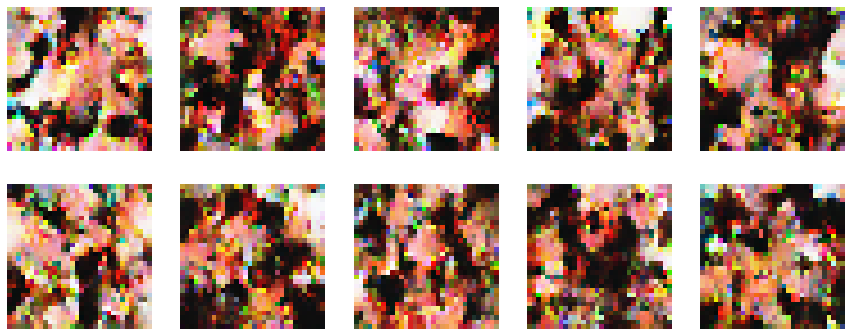

	log_pz = -1.4058
	log_d = 3120.2141
	log_pz = -1.4016
	log_d = 3061.3530
	log_pz = -1.3911
	log_d = 3006.2830
	log_pz = -1.3977
	log_d = 3139.4270
	log_pz = -1.3967
	log_d = 3072.8218
	log_pz = -1.4051
	log_d = 3083.8862
	log_pz = -1.4198
	log_d = 3194.9143
	log_pz = -1.4066
	log_d = 3138.3079
	log_pz = -1.3855
	log_d = 3039.8030
	log_pz = -1.3987
	log_d = 2818.7249
	log_pz = -1.4128
	log_d = 2931.5625
	log_pz = -1.4092
	log_d = 3187.1118
	log_pz = -1.3810
	log_d = 3308.2212
EPOCH : 5
	log_pz = -1.4261
	log_d = 3296.7822
	log_pz = -1.4050
	log_d = 3322.3999
	log_pz = -1.4167
	log_d = 3017.0505
	log_pz = -1.4254
	log_d = 2919.1443
	log_pz = -1.4417
	log_d = 3217.2388
	log_pz = -1.4899
	log_d = 3142.8064
	log_pz = -1.5203
	log_d = 2751.0864
	log_pz = -1.4424
	log_d = 2847.1035
	log_pz = -1.3800
	log_d = 2537.5996
	log_pz = -1.3730
	log_d = 2606.8518
	log_pz = -1.3869
	log_d = 2660.5549
	log_pz = -1.3846
	log_d = 2796.0535
	log_pz = -1.3961
	log_d = 2682.2361
	log_pz = -1.3872
	log_d = 2

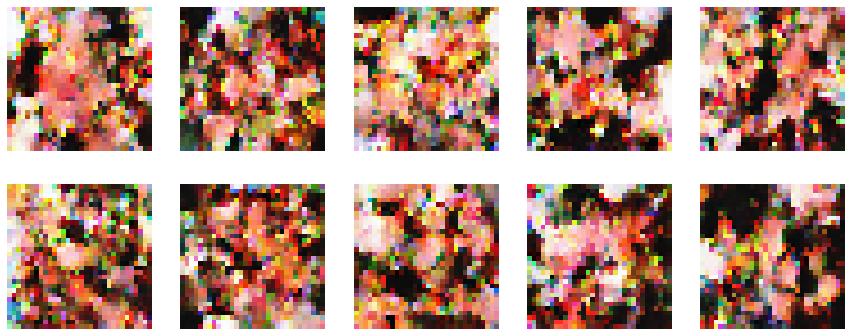

	log_pz = -1.4043
	log_d = 2848.7549
	log_pz = -1.3746
	log_d = 2990.7473
	log_pz = -1.4031
	log_d = 2931.0654
	log_pz = -1.4274
	log_d = 2927.3452
	log_pz = -1.4085
	log_d = 3094.6396
	log_pz = -1.4028
	log_d = 3084.2395
	log_pz = -1.4133
	log_d = 3073.0010
	log_pz = -1.4079
	log_d = 3029.9863
	log_pz = -1.3989
	log_d = 3023.9429
	log_pz = -1.3850
	log_d = 3197.1313
	log_pz = -1.4105
	log_d = 3051.0630
	log_pz = -1.3938
	log_d = 2943.2241
	log_pz = -1.3908
	log_d = 2968.2686
	log_pz = -1.4024
	log_d = 3203.6992
	log_pz = -1.4020
	log_d = 3415.7991
	log_pz = -1.4677
	log_d = 3262.4419
	log_pz = -1.4309
	log_d = 3066.4287
	log_pz = -1.3946
	log_d = 3123.0957
	log_pz = -1.4032
	log_d = 2884.8750
	log_pz = -1.3754
	log_d = 2897.7051
	log_pz = -1.4015
	log_d = 2879.1658
	log_pz = -1.3980
	log_d = 3214.2793
	log_pz = -1.4101
	log_d = 2940.1655
	log_pz = -1.4004
	log_d = 2993.2107
	log_pz = -1.3985
	log_d = 2918.4663
	log_pz = -1.4072
	log_d = 3125.5117
	log_pz = -1.4030
	log_d = 3238.3828
	

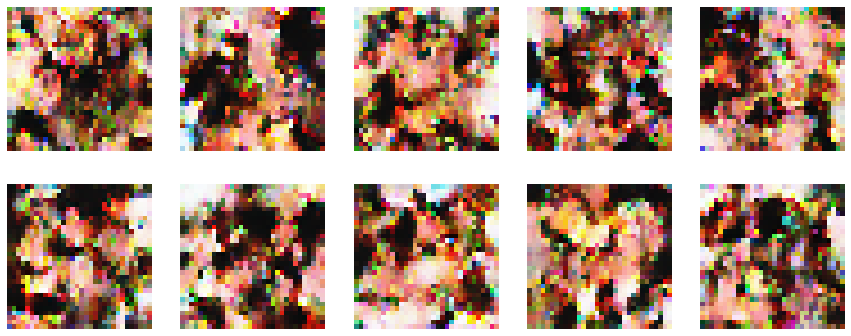

	log_pz = -1.3961
	log_d = 3140.5122
	log_pz = -1.3966
	log_d = 3204.0552
	log_pz = -1.4045
	log_d = 2893.9468
	log_pz = -1.3980
	log_d = 3414.0190
	log_pz = -1.4067
	log_d = 3184.3706
	log_pz = -1.4012
	log_d = 3029.3311
	log_pz = -1.3914
	log_d = 2956.4253
	log_pz = -1.3910
	log_d = 3253.7493
	log_pz = -1.3860
	log_d = 3325.9099
	log_pz = -1.4280
	log_d = 2987.8765
	log_pz = -1.4188
	log_d = 3270.2847
	log_pz = -1.4003
	log_d = 2979.3545
	log_pz = -1.3850
	log_d = 3309.5356
	log_pz = -1.4079
	log_d = 3179.1638
	log_pz = -1.4000
	log_d = 3031.9114
	log_pz = -1.3894
	log_d = 3165.8767
	log_pz = -1.4374
	log_d = 3108.8884
	log_pz = -1.4132
	log_d = 3140.7900
	log_pz = -1.3909
	log_d = 3076.1245
	log_pz = -1.4051
	log_d = 3073.4971
	log_pz = -1.3950
	log_d = 3209.0779
	log_pz = -1.3939
	log_d = 3307.5623
	log_pz = -1.4194
	log_d = 3111.1226
	log_pz = -1.4027
	log_d = 2976.6636
	log_pz = -1.4111
	log_d = 3056.6511
	log_pz = -1.4252
	log_d = 3294.4712
	log_pz = -1.4272
	log_d = 2913.8501
	

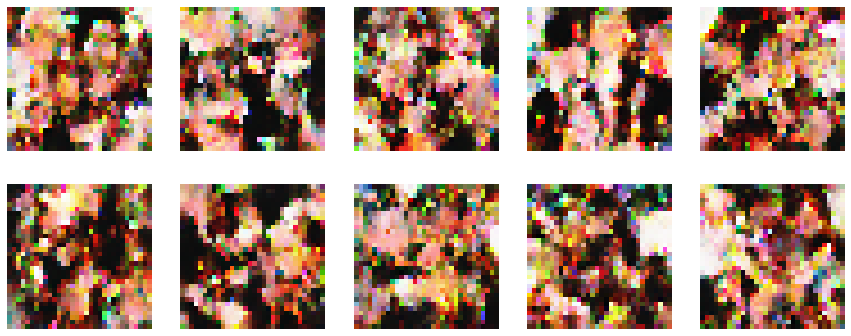

	log_pz = -1.3876
	log_d = 3271.5835
	log_pz = -1.4246
	log_d = 3044.7280
	log_pz = -1.3965
	log_d = 3431.9619
	log_pz = -1.3888
	log_d = 3043.6074
	log_pz = -1.4098
	log_d = 3255.3457
	log_pz = -1.4001
	log_d = 2915.5000
	log_pz = -1.4131
	log_d = 3199.0522
	log_pz = -1.4335
	log_d = 3068.4136
	log_pz = -1.3921
	log_d = 3094.5662
	log_pz = -1.3810
	log_d = 3053.8342
	log_pz = -1.3948
	log_d = 3113.3232
	log_pz = -1.4116
	log_d = 3413.9785
	log_pz = -1.4124
	log_d = 3124.6787
	log_pz = -1.4021
	log_d = 3165.5847
	log_pz = -1.3942
	log_d = 3214.9014
	log_pz = -1.3983
	log_d = 3229.0183
	log_pz = -1.3992
	log_d = 3072.4570
	log_pz = -1.3978
	log_d = 3405.3513
	log_pz = -1.3958
	log_d = 3374.3315
	log_pz = -1.4147
	log_d = 3107.0247
	log_pz = -1.3960
	log_d = 3113.3228
	log_pz = -1.4248
	log_d = 3025.5095
	log_pz = -1.4275
	log_d = 3251.7078
	log_pz = -1.4020
	log_d = 3034.9548
	log_pz = -1.3648
	log_d = 3216.8569
	log_pz = -1.3866
	log_d = 3189.4238
	log_pz = -1.4014
	log_d = 3516.6328
	

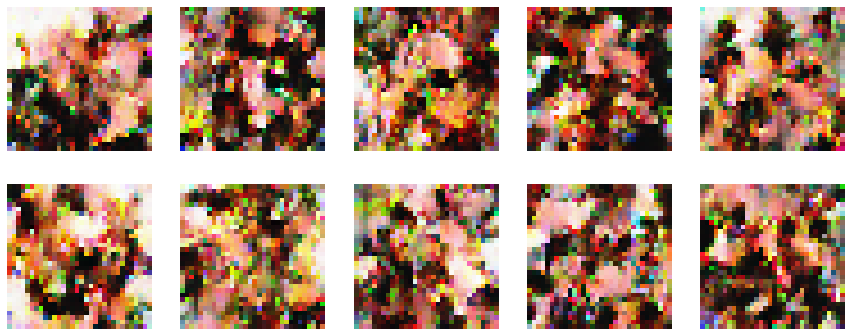

	log_pz = -1.4076
	log_d = 3166.8345
	log_pz = -1.4309
	log_d = 3177.9614
	log_pz = -1.4274
	log_d = 3051.8511
	log_pz = -1.3927
	log_d = 3115.3933
	log_pz = -1.3963
	log_d = 3069.1768
	log_pz = -1.3788
	log_d = 2858.0273
	log_pz = -1.3640
	log_d = 3079.3064
	log_pz = -1.3850
	log_d = 3067.2434
	log_pz = -1.4254
	log_d = 3185.0835
	log_pz = -1.4340
	log_d = 3252.9949
	log_pz = -1.4251
	log_d = 3277.5908
	log_pz = -1.4168
	log_d = 3026.9292
	log_pz = -1.3907
	log_d = 3234.2515
	log_pz = -1.4011
	log_d = 2964.1946
	log_pz = -1.3836
	log_d = 3270.2185
	log_pz = -1.3867
	log_d = 2958.8777
	log_pz = -1.4021
	log_d = 3272.9197
	log_pz = -1.3922
	log_d = 3346.5208
	log_pz = -1.4040
	log_d = 3060.0640
	log_pz = -1.4313
	log_d = 3265.5488
	log_pz = -1.4266
	log_d = 3085.4824
	log_pz = -1.4152
	log_d = 3243.2339
	log_pz = -1.3991
	log_d = 3003.0259
	log_pz = -1.4076
	log_d = 3351.0437
	log_pz = -1.4118
	log_d = 3242.5952
	log_pz = -1.4009
	log_d = 3003.4722
	log_pz = -1.3897
	log_d = 3011.9204
	

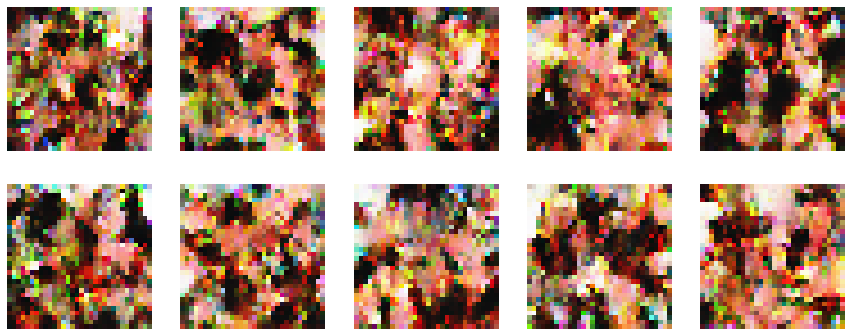

	log_pz = -1.4136
	log_d = 3139.9446
	log_pz = -1.3878
	log_d = 3045.2776
	log_pz = -1.3920
	log_d = 2983.7346
	log_pz = -1.4058
	log_d = 3220.4829
	log_pz = -1.4019
	log_d = 2969.6462
	log_pz = -1.4055
	log_d = 3003.7615
	log_pz = -1.3915
	log_d = 3139.2603
	log_pz = -1.3978
	log_d = 3242.5537
	log_pz = -1.4064
	log_d = 3321.2715
	log_pz = -1.3952
	log_d = 3305.3557
	log_pz = -1.3900
	log_d = 3358.0027
	log_pz = -1.4090
	log_d = 3340.3503
	log_pz = -1.4077
	log_d = 3151.2783
	log_pz = -1.4147
	log_d = 3192.4856
	log_pz = -1.4105
	log_d = 2893.8613
	log_pz = -1.3955
	log_d = 3129.9810
	log_pz = -1.3820
	log_d = 3317.0889
	log_pz = -1.3802
	log_d = 3338.2041
	log_pz = -1.3959
	log_d = 3318.7407
	log_pz = -1.4136
	log_d = 3232.0801
	log_pz = -1.4011
	log_d = 3153.3257
	log_pz = -1.3905
	log_d = 3374.3481
	log_pz = -1.4011
	log_d = 3167.1562
	log_pz = -1.4021
	log_d = 3484.6897
	log_pz = -1.4103
	log_d = 3271.6082
	log_pz = -1.4024
	log_d = 3436.0732
	log_pz = -1.4061
	log_d = 3214.3633
	

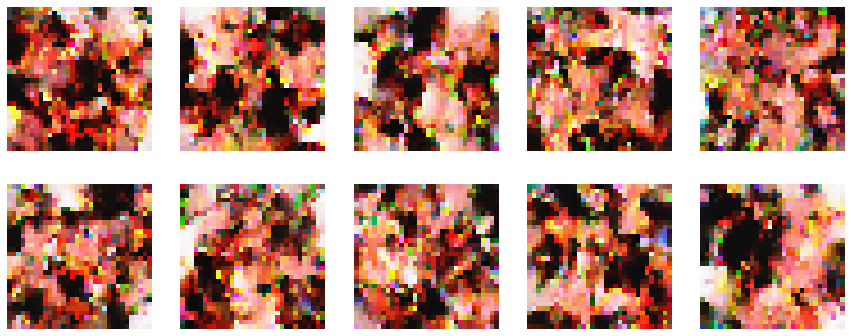

	log_pz = -1.4372
	log_d = 3113.0447
	log_pz = -1.4277
	log_d = 3106.3550
	log_pz = -1.3825
	log_d = 2971.6206
	log_pz = -1.3715
	log_d = 3189.2446
	log_pz = -1.3824
	log_d = 3214.9167
	log_pz = -1.4051
	log_d = 3079.9829
	log_pz = -1.4174
	log_d = 3351.9968
	log_pz = -1.4259
	log_d = 3109.4348
	log_pz = -1.4276
	log_d = 3397.6272
	log_pz = -1.4153
	log_d = 2952.9080
	log_pz = -1.4098
	log_d = 3089.8296
	log_pz = -1.4002
	log_d = 2981.8418
	log_pz = -1.3735
	log_d = 3367.5151
EPOCH : 6
	log_pz = -1.3979
	log_d = 3257.5872


KeyboardInterrupt: ignored

In [17]:
plt.rcParams["figure.figsize"] = [15., 6.]

for epoch in range(saved_epoch + 1, n_epochs):
  for i, x in enumerate(train_data, start=1):
    x = x.to(device)

    # Dequantization & logit mapping
    x = torch.clip(x + torch.randn_like(x) * 0.01, 0, 3)
    x = torch.logit(0.05 + 0.95 * x / 3.05)

    # Forward pass
    z, log_d = model(x)
    log_pz = target.log_prob(z)

    loss = - (log_pz.sum(dim=(1, 2, 3)) + log_d).mean()

    print(f"\tlog_pz = {log_pz.mean().item():.4f}")
    print(f"\tlog_d = {log_d.mean().item():.4f}")

    opt.zero_grad()
    loss.backward()
    opt.step()

    # Sampling
    if i % 50 == 0:
      print("\t", i)
      with torch.no_grad():
        W = model.inverse(torch.randn(10, 3, 32, 32).to(device))
        W = F.sigmoid(W)
        W *= 255
        W = W.permute(0, 2, 3, 1)
        img = W.cpu().numpy()
        img = img.astype(np.uint8)

        for i in range(2):
          for j in range(5):
            plt.subplot(2, 5, i * 5 + j + 1)
            plt.axis('off')
            plt.imshow(img[i * 5 + j])
        plt.show()

  print(f"EPOCH : {epoch + 1}")
  torch.save(model.state_dict(), f'/content/drive/MyDrive/RealNVP/real_nvp_updated_{epoch}.pt')

### Interpolation

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


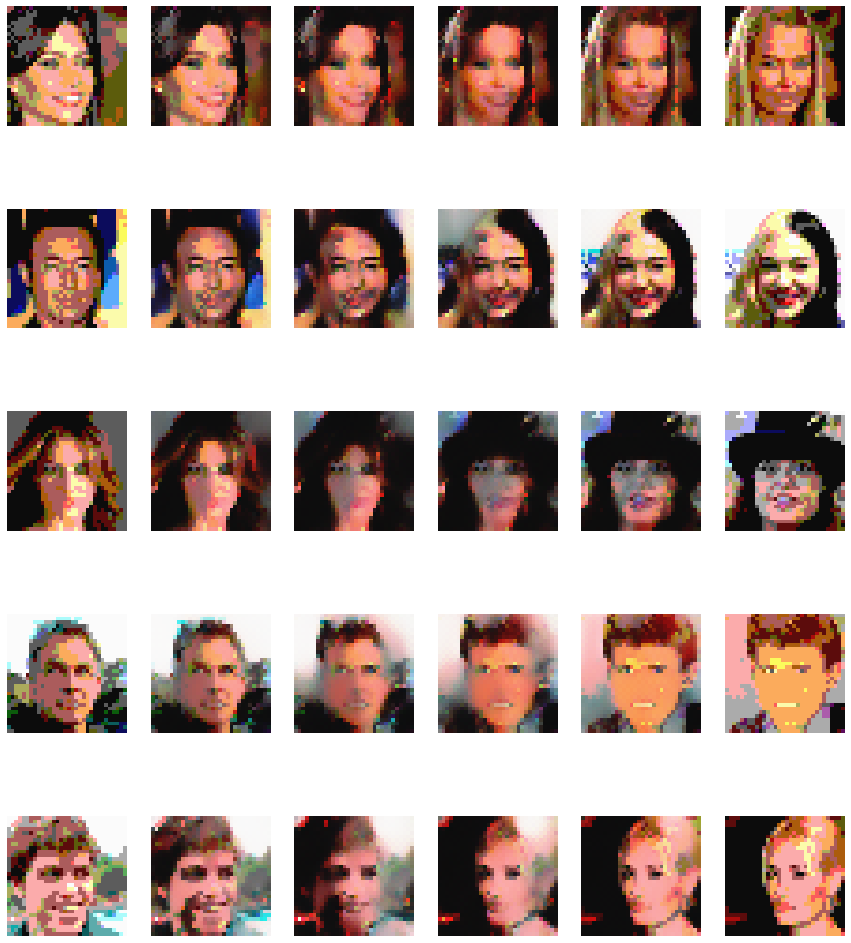

In [21]:
plt.rcParams["figure.figsize"] = [15., 18.]

with torch.no_grad():
  X = train_dataset[:10].to(device)
  X = torch.logit(0.05 + 0.95 * X / 3.05)

  Y = torch.empty((5, 6, 3, 32, 32), device=device)

  for i in range(5):
    Y[i, 0] = X[2 * i]
    Y[i, 5] = X[2 * i + 1]

    z1, _ = model(X[2 * i].unsqueeze(0))
    z2, _ = model(X[2 * i + 1].unsqueeze(0))

    direction = (z2 - z1) / 5

    for j in range(1, 5):
      Y[i, j] = model.inverse(z1 + j * direction)
  
  Y = Y.reshape(-1, 3, 32, 32)
  Y = Y.permute((0, 2, 3, 1))
  Y = F.sigmoid(Y)
  Y *= 255
  img = Y.cpu().numpy()
  img = img.astype(np.uint8)

  for i in range(5):
    for j in range(6):
      idx = i * 6 + j 
      plt.subplot(5, 6, idx + 1)
      plt.axis('off')
      plt.imshow(img[idx])
  plt.show()

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q1_a(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



torch.Size([30, 3, 32, 32])
Final Test Loss: 0.4065


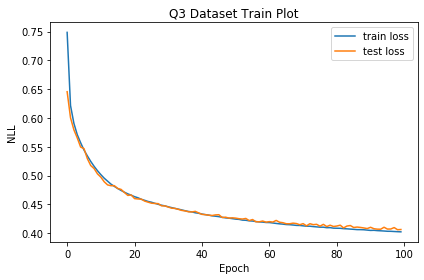

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


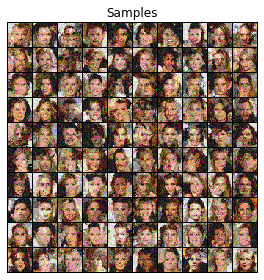

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


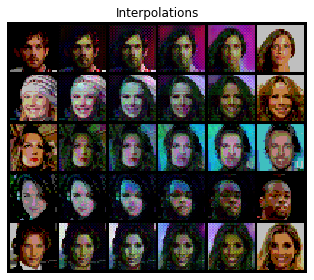

In [ ]:
q1_save_results(q1_a, 'a')

## Part (b): Exploring bad masking schemes

The choice of masking or partitioning scheme affects the quality of the final flow model. In this part, design a *bad* masking scheme and train a model with it on the same CelebA dataset. 

**Provide the same deliverables as part (a)**

### Solution

In [ ]:
def q1_b(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
  - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



torch.Size([30, 3, 32, 32])
Final Test Loss: 0.6963


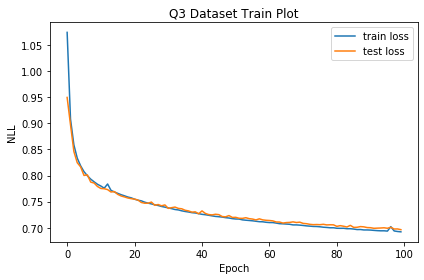

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


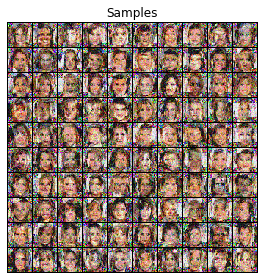

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


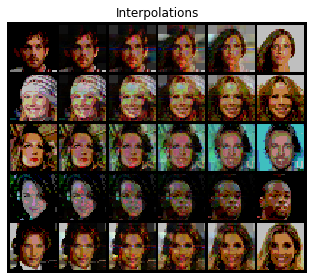

In [ ]:
q1_save_results(q1_b, 'b')

## Bonus 1: Multiscale RealNVP
Following the alternating checkerboard, channel squeeze, and channel partition scheme used in https://arxiv.org/abs/1605.08803, learn a multiscale RealNVP model on our CelebA dataset used in Question 3. We expect the same deliverables as in Question 3; additionally, make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def b1(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
  - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q1_save_results(b1, 'bonus1')

## Bonus 2: Glow
The Glow paper introduces the invertible 1x1 convolution as a replacement for the permutation scheme that follows the channel squeezing step. Use this in your model from Question 3, and report the same deliverables. Make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def b2(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 3, H, W) of samples with values in [0, 1]
  - a numpy array of size (30, 3, H, W) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q1_save_results(b2, 'bonus2')